# Team - Sorry for being Late

#### Federico Silvestri (10585807)
#### Manjith kumar Reddy Sirigireddy (10747440) 
#### Raihan Rasheed (10777129)
#### Marcela Reyes (10510509)


# 0.Introductory information

*Data were recorded during a 5 months period (June to October, 2020) on an high speed fleet and are relative to date from external passenger doors. The vehicles are composed by 8 cars: DM1 (or 01), TT2 (or 02), M3 (or 03), T4 (or 04), T5 (or 05), M6 (or 06), TT7 (or 07), DM8 (or 08). 
On head/tail coaches (DM1 and DM8) there are 2 doors (1 per side), on the other six coaches there are 4 doors (2 per side) on each car.*

*The opening procedure consists in 3 phases:*
+ *Step opening*
+ *Door unlocking*
+ *Door opening*

*The closing procedure consists in 3 phases too:*
+ *Door closing*
+ *Door locking*
+ *Step closing*

*Each time the train stops and open/closes the doors, one raw of data for each door is recorded.
If during the stop a single door does not open, it will record, for itself, the value 0 for all the current and time variables.
A single door on the vehicle is identified by the relative Door Control Unit (DCU) and the car.
For example, the Door1 on coach TT2 is identified by DCU1 and car02.
This information is recorded in the variable “processor_name”.*

In the dataframe there are 14 variables for which the following explanation has been given:
+ *sample_timestap  :  Date and time of signal recording*
+ *vehicle_name     :  Name id of the vehicle*
+ *processor_name   :  Identifies the door on the vehicle: the format is “DCUX.carY”, where X is the door position on the                           coach,and Y is the car number. Example: DCU3.car05 is the Door 3 of the car T5*	
+ *ICstCarNo        :  Car number*
+ *IDoorCloseCurr   :  Door mean measured current in closing*
+ *IDoorClosingTime :  Closing time of the door in tenth of seconds*
+ *IDoorLockCurr    :  Door mean measured locking current*
+ *IDoorOpenCurr    :  Door mean measured current in opening*
+ *IDoorOpenTime    :  Opening time of the door in tenth of seconds*
+ *IDoorUnlockCurr  :  Door mean measured unlocking current*
+ *IStepCloseCurr   :  Step mean measured closing current*
+ *IStepClosingTime :  Closing time of the step in tenth of seconds*
+ *IStepOpenCurr    :  Step mean measured opening current*
+ *IStepOpenTime    :  Opening time of the step in tenth of seconds*
*All currents have been measured in mA and all times in tenth of seconds (0.1s).

# 1.Library Handling

In the following cell we import all libraries and functions that will be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import matplotlib

In [2]:
display(HTML("<style>div.output_scroll { height: 30em; }</style>"))

We import data given by Hitachi about train doors and perform some data rearrangement extracting useful infos about time:

In [3]:
df = pd.read_csv('doors_data_polimi.csv') 

In [4]:
DataFrame_Profile = ProfileReport(df) 

Converting the sample timestamp in the dataframe into date, time, day, and month

In [5]:
df['sample_timestamp'] = pd.to_datetime(df['sample_timestamp'])

In [6]:
df['day']   = df['sample_timestamp'].dt.day_name()
df['date'] = df['sample_timestamp'].dt.date
df['time']  = df['sample_timestamp'].dt.time
df['month'] = df['sample_timestamp'].dt.month

In [7]:
df = df.sort_values('sample_timestamp').reset_index(drop = True)

And we select out of processor_name the door number, which happens to be identified by the fourth letter of the string, 
and add to each row the corresponding door:

In [8]:
Doors = [0]*len(df['processor_name'])
for i in range(0,len(df['processor_name'])):
     Doors[i] = df['processor_name'][i][3]

In [9]:
df['Door'] = Doors

In [10]:
df.head()

sample_timestamp  vehicle_name   processor_name  ICstCarNo  \
0 2020-06-01 10:09:21          20.0  DCU2.car08.lCst          8   
1 2020-06-01 10:09:21          20.0  DCU3.car02.lCst          2   
2 2020-06-01 10:09:21          20.0  DCU1.car02.lCst          2   
3 2020-06-01 10:09:21          20.0  DCU3.car03.lCst          3   
4 2020-06-01 10:09:21          20.0  DCU2.car05.lCst          5   

   IDoorCloseCurr  IDoorClosingTime  IDoorLockCurr  IDoorOpenCurr  \
0               0                 0              0              0   
1               0                 0              0              0   
2               0                 0              0              0   
3               0                 0              0              0   
4               0                 0              0              0   

   IDoorOpenTime  IDoorUnlockCurr  IStepCloseCurr  IStepClosingTime  \
0              0                0               0                 0   
1              0                0               0                 0   
2              0                0               0                 0   
3              0                0               0                 0   
4              0                0               0                 0   

   IStepOpenCurr  IStepOpenTime     day        date      time  month Door  
0              0              0  Monday  2020-06-01  10:09:21      6    2  
1              0              0  Monday  2020-06-01  10:09:21      6    3  
2              0              0  Monday  2020-06-01  10:09:21      6    1  
3              0              0  Monday  2020-06-01  10:09:21      6    3  
4              0              0  Monday  2020-06-01  10:09:21      6    2

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883825 entries, 0 to 1883824
Data columns (total 19 columns):
 #   Column            Dtype         
---  ------            -----         
 0   sample_timestamp  datetime64[ns]
 1   vehicle_name      float64       
 2   processor_name    object        
 3   ICstCarNo         int64         
 4   IDoorCloseCurr    int64         
 5   IDoorClosingTime  int64         
 6   IDoorLockCurr     int64         
 7   IDoorOpenCurr     int64         
 8   IDoorOpenTime     int64         
 9   IDoorUnlockCurr   int64         
 10  IStepCloseCurr    int64         
 11  IStepClosingTime  int64         
 12  IStepOpenCurr     int64         
 13  IStepOpenTime     int64         
 14  day               object        
 15  date              object        
 16  time              object        
 17  month             int64         
 18  Door              object        
dtypes: datetime64[ns](1), float64(1), int64(12), object(5)
memory usage: 273.1+ MB


#  2.Data Analysis

In [12]:
nan = df[df.isna().any(axis=1)]

In [13]:
nan

sample_timestamp  vehicle_name   processor_name  ICstCarNo  \
618465 2020-08-07 14:31:35           NaN  DCU3.car03.lCst          3   
618466 2020-08-07 14:31:35           NaN  DCU2.car08.lCst          8   
618467 2020-08-07 14:31:35           NaN  DCU1.car02.lCst          2   
618468 2020-08-07 14:31:35           NaN  DCU1.car01.lCst          1   
618469 2020-08-07 14:31:35           NaN  DCU3.car02.lCst          2   
...                    ...           ...              ...        ...   
896767 2020-08-24 14:04:08           NaN  DCU1.car04.lCst          4   
896768 2020-08-24 14:04:08           NaN  DCU1.car07.lCst          7   
896769 2020-08-24 14:04:08           NaN  DCU3.car05.lCst          5   
896770 2020-08-24 14:04:08           NaN  DCU1.car08.lCst          8   
896771 2020-08-24 14:04:08           NaN  DCU3.car02.lCst          2   

        IDoorCloseCurr  IDoorClosingTime  IDoorLockCurr  IDoorOpenCurr  \
618465               0                 0              0              0   
618466               0                 0              0              0   
618467               0                 0              0              0   
618468               0                 0              0              0   
618469               0                 0              0              0   
...                ...               ...            ...            ...   
896767               0                 0              0              0   
896768               0                 0              0              0   
896769               0                 0              0              0   
896770               0                 0              0              0   
896771               0                 0              0              0   

        IDoorOpenTime  IDoorUnlockCurr  IStepCloseCurr  IStepClosingTime  \
618465              0                0               0                 0   
618466              0                0               0                 0   
618467              0                0               0                 0   
618468              0                0               0                 0   
618469              0                0               0                 0   
...               ...              ...             ...               ...   
896767              0                0               0                 0   
896768              0                0               0                 0   
896769              0                0               0                 0   
896770              0                0               0                 0   
896771              0                0               0                 0   

        IStepOpenCurr  IStepOpenTime     day        date      time  month Door  
618465              0              0  Friday  2020-08-07  14:31:35      8    3  
618466              0              0  Friday  2020-08-07  14:31:35      8    2  
618467              0              0  Friday  2020-08-07  14:31:35      8    1  
618468              0              0  Friday  2020-08-07  14:31:35      8    1  
618469              0              0  Friday  2020-08-07  14:31:35      8    3  
...               ...            ...     ...         ...       ...    ...  ...  
896767              0              0  Monday  2020-08-24  14:04:08      8    1  
896768              0              0  Monday  2020-08-24  14:04:08      8    1  
896769              0              0  Monday  2020-08-24  14:04:08      8    3  
896770              0              0  Monday  2020-08-24  14:04:08      8    1  
896771              0              0  Monday  2020-08-24  14:04:08      8    3  

[112 rows x 19 columns]

The data has less NaN values and all of them are in vehicle_name which might be because all the carriages does not belong 
to a single train or they might be under testing. Lets check on which date, time, day these values were recorded.

In [14]:
nan.profile_report()

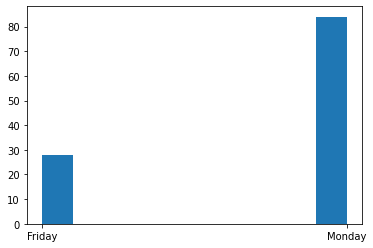

In [15]:
plt.hist(nan['day'])
plt.show()

In [16]:
f = nan[nan['day'] == "Friday"]

In [17]:
m = nan[nan['day'] == "Monday"]

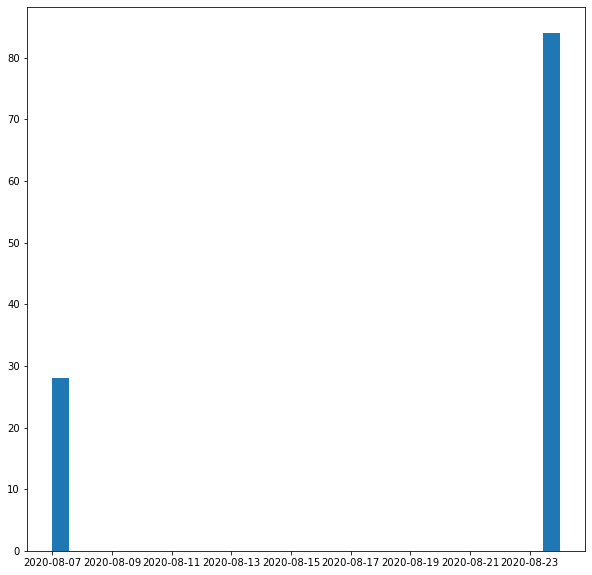

In [18]:
plt.figure(figsize= [10,10])
plt.hist(nan['date'], bins=30)
plt.show()

In [19]:
f["time"].unique()

array([datetime.time(14, 31, 35)], dtype=object)

In [20]:
m["time"].unique()

array([datetime.time(13, 23, 28), datetime.time(13, 56, 10),
       datetime.time(13, 56, 11), datetime.time(14, 4, 8)], dtype=object)

From the visualization of NaN values data we can see that the NaN values in the vehicle_name were recorded on 07-08-2020 
at 14:31:35, and on 23-08-2020 at 13:23:28, 13:56:10, 13:56:11, and 14:4:8 and out of 112 NaN data rows 108 were zeros recording which states that only 4 doors were opened out of 112 recordings.

As the NaN values are present in the Vehicle name and it consists of mostly zero values and only 4 occurances, we opt to drop the NaN values.

The data has lot of zero values which are because the doors werent used so no values was recorded by the processor. 
So keeping the zero values may not be effective so we opt to drop them.

First we drop both NANs and zero values:

In [21]:
df = df.dropna()
df_no_zeros = df.loc[(df!=0).all(axis=1)].reset_index(drop = True)

We now print for each train the mean values of time and current for some specific variables together with the number of occurrences for each train, with the underlying supposition that eventual abnormal behaviors would reflect on all the values  and not just the specific chosen ones:

In [22]:
number_of_occurrences = []
avg_time = []
avg_curr = []
for i in range(1,51):
    t = df_no_zeros['IDoorClosingTime'][df_no_zeros['vehicle_name'] == i].mean()
    c = df_no_zeros['IDoorCloseCurr'][df_no_zeros['vehicle_name'] == i].mean()
    n = len(df_no_zeros['IDoorCloseCurr'][df_no_zeros['vehicle_name'] == i])
    print('The train number %s has a mean DoorCloseCurr of %.1f, a mean time for closing of %.1f \
                                                             and a number of occurrences of %s'%(i,c,t,n))
    avg_time.append(t)
    avg_curr.append(c)
    number_of_occurrences.append(n)

The train number 1 has a mean DoorCloseCurr of 676.6, a mean time for closing of 47.8                                                              and a number of occurrences of 13130
The train number 2 has a mean DoorCloseCurr of 634.6, a mean time for closing of 47.8                                                              and a number of occurrences of 13626
The train number 3 has a mean DoorCloseCurr of 655.1, a mean time for closing of 47.8                                                              and a number of occurrences of 14421
The train number 4 has a mean DoorCloseCurr of 650.5, a mean time for closing of 47.8                                                              and a number of occurrences of 10185
The train number 5 has a mean DoorCloseCurr of 646.5, a mean time for closing of 47.8                                                              and a number of occurrences of 14410
The train number 6 has a mean DoorCloseCurr of 649.1, a mean time for closing of

The train number 49 has a mean DoorCloseCurr of 771.4, a mean time for closing of 47.8                                                              and a number of occurrences of 14952
The train number 50 has a mean DoorCloseCurr of 735.3, a mean time for closing of 47.8                                                              and a number of occurrences of 16052


And we make a new dataframe out of it, dfm (mean):

In [23]:
dfm = pd.DataFrame()
dfm['n_of_occurrences'] = number_of_occurrences
dfm['avg_curr']         = avg_curr
dfm['avg_time']         = avg_time
dfm['train_number']     = dfm.index +1
dfm.head()

n_of_occurrences    avg_curr   avg_time  train_number
0             13130  676.609901  47.794973             1
1             13626  634.596213  47.808895             2
2             14421  655.144581  47.786145             3
3             10185  650.518999  47.808346             4
4             14410  646.537682  47.802498             5

In [24]:
#ProfileReport(dfm)

*The previous cells give us two information :*

+ *there's no recording of train number 21;*

+ *some trains did less travels.*

*We drop train n. 21 as there's no recording*

In [25]:
dfm = dfm[dfm['train_number'] != 21]

*We now check the average time  together with the distribution of occurrences:*

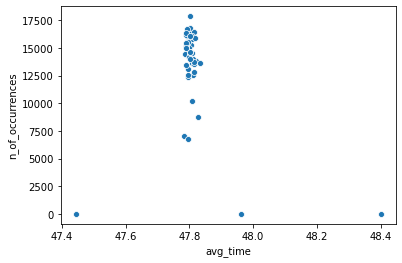

In [26]:
sns.scatterplot(dfm['avg_time'],dfm['n_of_occurrences'])

*It's clear that trains that had less than 5000 occurrences must either be diffferent from the others or have had some troubles. In both cases they may have to be considered outliers so we perform some more analysis.*

*first we select all rows that respect the said condition and create a dataframe out of them*

In [27]:
strange_trains = dfm['train_number'][dfm['n_of_occurrences'] < 5000]
strange_trains

14    15
24    25
47    48
Name: train_number, dtype: int64

In [28]:
df_strange = pd.DataFrame()
for i in strange_trains :
    df_strange = df_strange.append(df_no_zeros[df_no_zeros['vehicle_name'] == i])

In [29]:
df_strange = df_strange.reset_index(drop = True)
df_strange#.head()

sample_timestamp  vehicle_name   processor_name  ICstCarNo  \
0  2020-06-10 07:12:36          15.0  DCU3.car06.lCst          6   
1  2020-06-10 07:12:36          15.0  DCU2.car07.lCst          7   
2  2020-06-10 07:12:36          15.0  DCU1.car03.lCst          3   
3  2020-06-10 07:12:36          15.0  DCU4.car02.lCst          2   
4  2020-06-10 07:12:36          15.0  DCU4.car07.lCst          7   
..                 ...           ...              ...        ...   
66 2020-07-10 03:37:31          48.0  DCU4.car06.lCst          6   
67 2020-07-30 06:58:48          48.0  DCU2.car02.lCst          2   
68 2020-08-12 18:22:02          48.0  DCU4.car06.lCst          6   
69 2020-08-13 14:43:56          48.0  DCU1.car06.lCst          6   
70 2020-08-13 14:43:57          48.0  DCU2.car06.lCst          6   

    IDoorCloseCurr  IDoorClosingTime  IDoorLockCurr  IDoorOpenCurr  \
0              672                48            672            480   
1              624                48            384            576   
2              624                46            576            528   
3              672                47            720            624   
4              672                47            432            432   
..             ...               ...            ...            ...   
66             768                49            624            624   
67             672                48            240            480   
68             768                47            432            672   
69             768                47            336            816   
70             624                45            240            480   

    IDoorOpenTime  IDoorUnlockCurr  IStepCloseCurr  IStepClosingTime  \
0              53              816             480                40   
1              52              768             480                40   
2              53              912             432                39   
3              52             1104             336                38   
4              52              720             672                42   
..            ...              ...             ...               ...   
66             52              480             480                39   
67             53              624             480                40   
68             52              672             480                39   
69             52              624             384                39   
70             52              576             480                38   

    IStepOpenCurr  IStepOpenTime        day        date      time  month Door  
0             240             28  Wednesday  2020-06-10  07:12:36      6    3  
1             336             28  Wednesday  2020-06-10  07:12:36      6    2  
2             288             28  Wednesday  2020-06-10  07:12:36      6    1  
3             192             27  Wednesday  2020-06-10  07:12:36      6    4  
4             528             30  Wednesday  2020-06-10  07:12:36      6    4  
..            ...            ...        ...         ...       ...    ...  ...  
66            480             29     Friday  2020-07-10  03:37:31      7    4  
67            384             29   Thursday  2020-07-30  06:58:48      7    2  
68            432             29  Wednesday  2020-08-12  18:22:02      8    4  
69            336             28   Thursday  2020-08-13  14:43:56      8    1  
70            336             28   Thursday  2020-08-13  14:43:57      8    2  

[71 rows x 19 columns]

In [30]:
df_strange['Door'] = [0]*len(df_strange['processor_name'])
for i in range(0,len(df_strange['processor_name'])):
    df_strange['Door'][i] = df_strange['processor_name'][i][3]

<ipython-input-30-1696e7cc0a6a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strange['Door'][i] = df_strange['processor_name'][i][3]


In [31]:
df_strange = df_strange.drop('processor_name', axis =1)
df_strange['Door']

0     3
1     2
2     1
3     4
4     4
     ..
66    4
67    2
68    4
69    1
70    2
Name: Door, Length: 71, dtype: int64

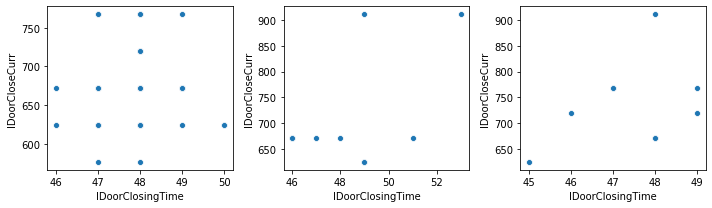

In [32]:
j = 1
plt.figure(figsize=(10, 3))
for i in strange_trains:
    plt.subplot(1,3,j)
    j = j + 1
    sns.scatterplot(df_strange['IDoorClosingTime'][df_strange['vehicle_name'] == i],\
                df_strange['IDoorCloseCurr'][df_strange['vehicle_name'] == i])
plt.tight_layout()

*The previous graphs suggest that there might be some specific correlation with the current flowing and some other variable, so we check if it has something to do with doors.*

Following code will be repeated a few times only changing the variables, since the underlying structure is always the same.
We picked the trains with a strange number of occurrences, and for each of them, for each Car we plot the variables for each door, in order to show patterns or behaviors. The underlying theory is that if points began to split on straight lines 'out' of normal values then what we identified is a particular door, of a particular Car, of a particular train, that presents a steady, strange behavior and could use some manual inspection.

 Train number 15
 Car number 1
 Graph for Train number 15 Car number 1 and Door number 1-4


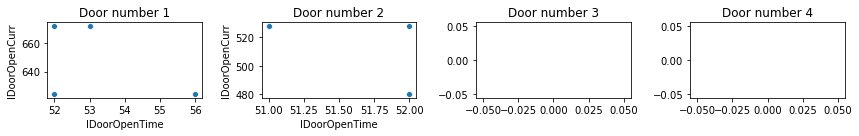

 Car number 2
 Graph for Train number 15 Car number 2 and Door number 1-4


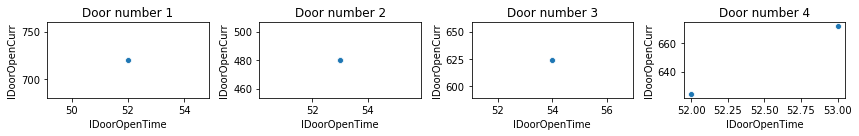

 Car number 3
 Graph for Train number 15 Car number 3 and Door number 1-4


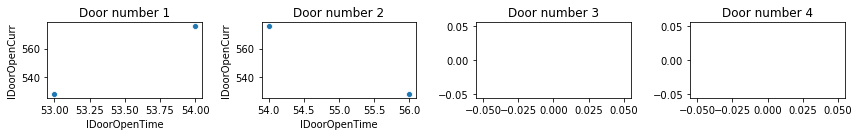

 Car number 4
 Graph for Train number 15 Car number 4 and Door number 1-4


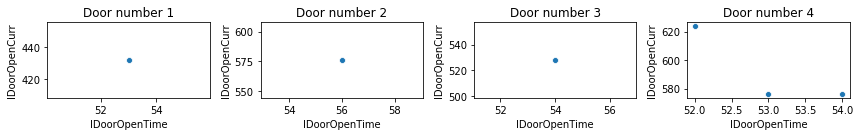

 Car number 5
 Graph for Train number 15 Car number 5 and Door number 1-4


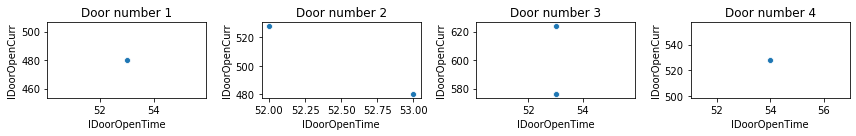

 Car number 6
 Graph for Train number 15 Car number 6 and Door number 1-4


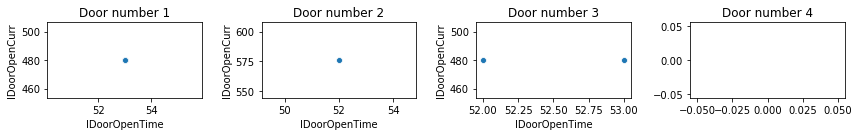

 Car number 7
 Graph for Train number 15 Car number 7 and Door number 1-4


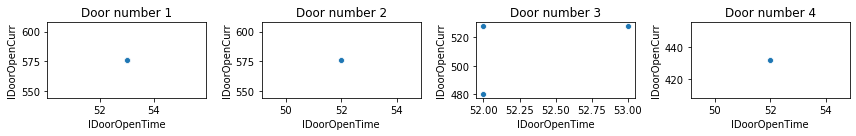

 Car number 8
 Graph for Train number 15 Car number 8 and Door number 1-4


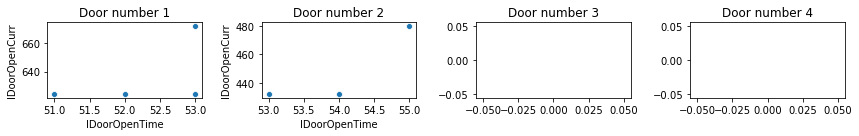

 Train number 25
 Car number 1
 Graph for Train number 25 Car number 1 and Door number 1-4


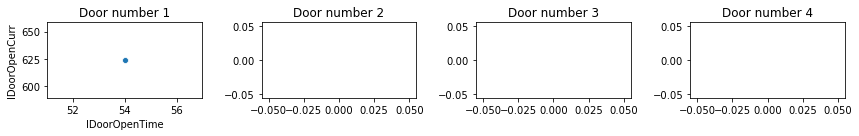

 Car number 2
 Graph for Train number 25 Car number 2 and Door number 1-4


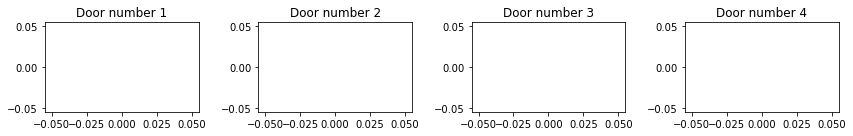

 Car number 3
 Graph for Train number 25 Car number 3 and Door number 1-4


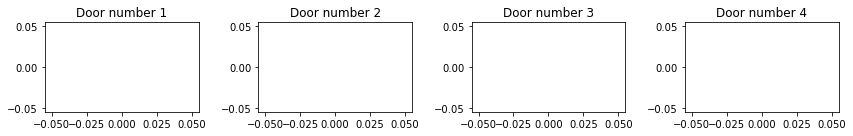

 Car number 4
 Graph for Train number 25 Car number 4 and Door number 1-4


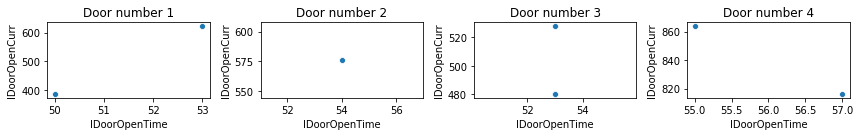

 Car number 5
 Graph for Train number 25 Car number 5 and Door number 1-4


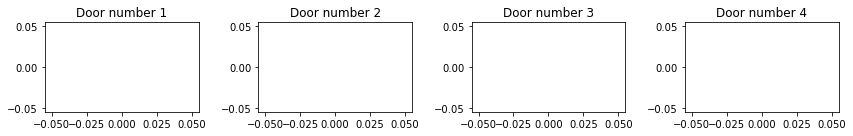

 Car number 6
 Graph for Train number 25 Car number 6 and Door number 1-4


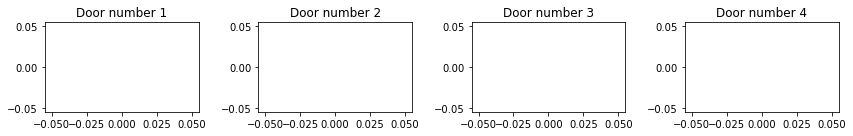

 Car number 7
 Graph for Train number 25 Car number 7 and Door number 1-4


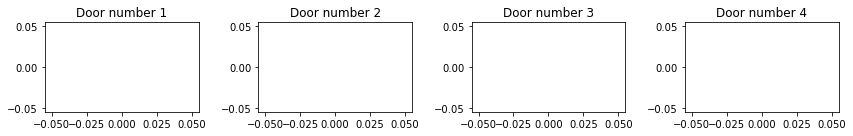

 Car number 8
 Graph for Train number 25 Car number 8 and Door number 1-4


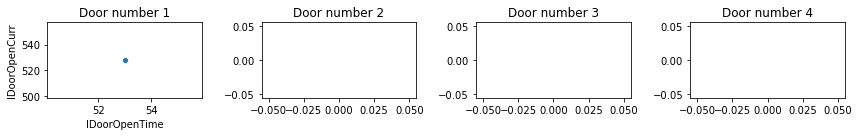

 Train number 48
 Car number 1
 Graph for Train number 48 Car number 1 and Door number 1-4


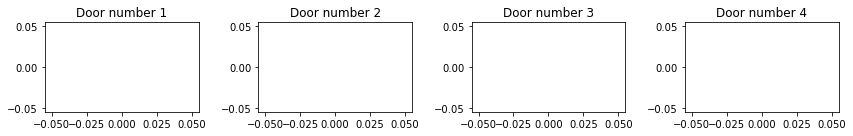

 Car number 2
 Graph for Train number 48 Car number 2 and Door number 1-4


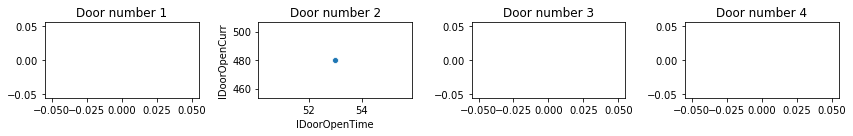

 Car number 3
 Graph for Train number 48 Car number 3 and Door number 1-4


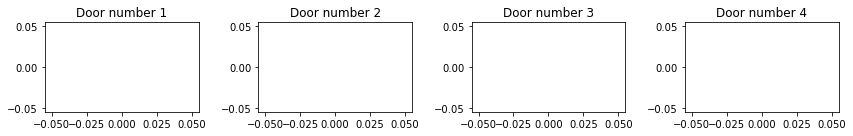

 Car number 4
 Graph for Train number 48 Car number 4 and Door number 1-4


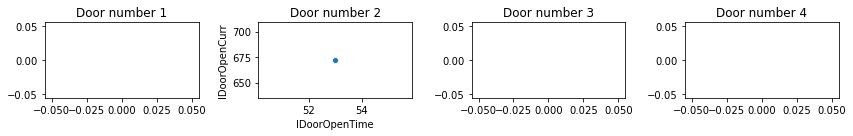

 Car number 5
 Graph for Train number 48 Car number 5 and Door number 1-4


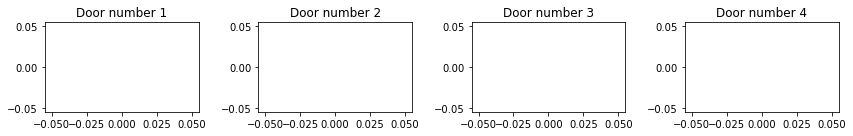

 Car number 6
 Graph for Train number 48 Car number 6 and Door number 1-4


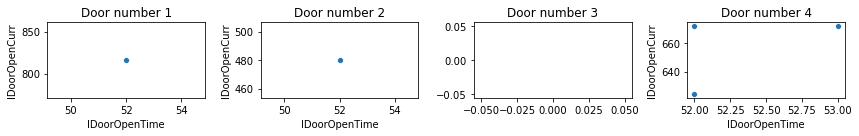

 Car number 7
 Graph for Train number 48 Car number 7 and Door number 1-4


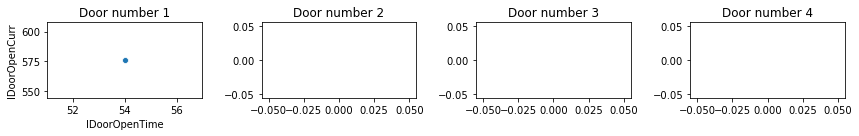

 Car number 8
 Graph for Train number 48 Car number 8 and Door number 1-4


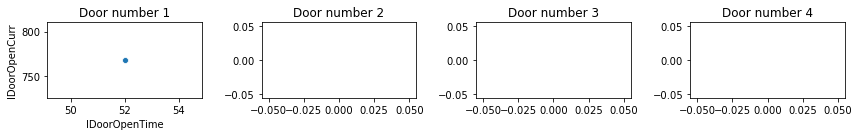

In [33]:
for i in strange_trains:
    print('\033[1m Train number %s' %i)
    for k in range(1,len(set(df_strange['ICstCarNo']))+1):
        plt.figure(figsize=(12, 2))
        print('\033[1m Car number %s' %k)
        print('\033[0m Graph for Train number %s Car number %s and Door number 1-4' %(i,k))
        for j in range(1,len(set(df_strange['Door']))+1):
            plt.subplot(1, 4, j)
            sns.scatterplot(df_strange['IDoorOpenTime'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i)& \
                    (df_strange['ICstCarNo'] == k)],\
                    df_strange['IDoorOpenCurr'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i) & \
                    (df_strange['ICstCarNo'] == k)])
            plt.title('Door number ' + str(j))
        plt.tight_layout()
        plt.show()

*Since points of same door didn't split in single lines in neither Opening current nor Opening time it means that doors are not responsible for this splitting behavior in terms of both current and time.\
We now try the same with closing times and currents:*

 Train number 15
 Car number 1
 Graph for Train number 15 Car number 1 and Door number 1-4


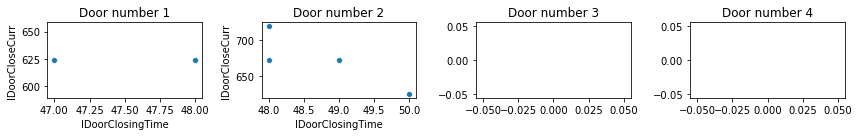

 Car number 2
 Graph for Train number 15 Car number 2 and Door number 1-4


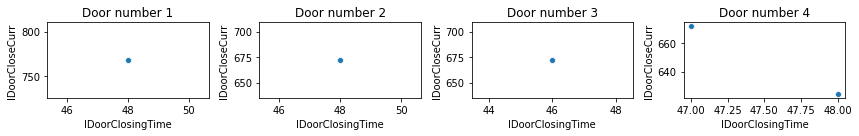

 Car number 3
 Graph for Train number 15 Car number 3 and Door number 1-4


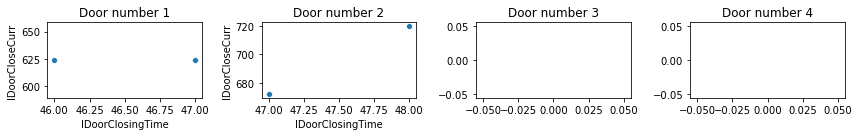

 Car number 4
 Graph for Train number 15 Car number 4 and Door number 1-4


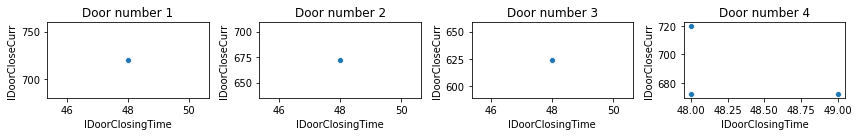

 Car number 5
 Graph for Train number 15 Car number 5 and Door number 1-4


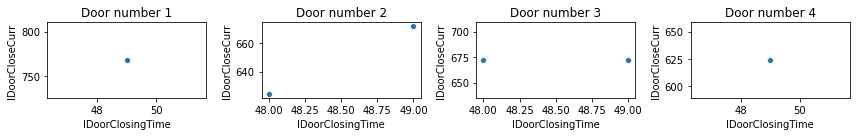

 Car number 6
 Graph for Train number 15 Car number 6 and Door number 1-4


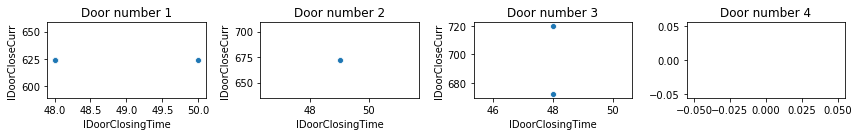

 Car number 7
 Graph for Train number 15 Car number 7 and Door number 1-4


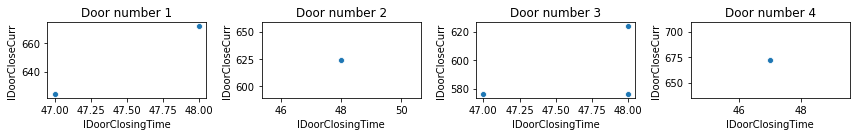

 Car number 8
 Graph for Train number 15 Car number 8 and Door number 1-4


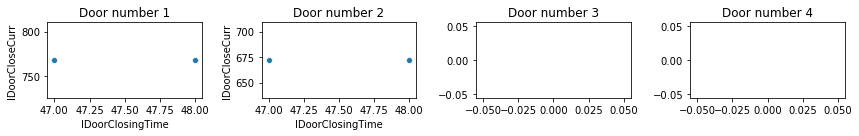

 Train number 25
 Car number 1
 Graph for Train number 25 Car number 1 and Door number 1-4


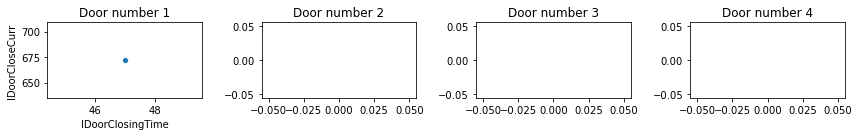

 Car number 2
 Graph for Train number 25 Car number 2 and Door number 1-4


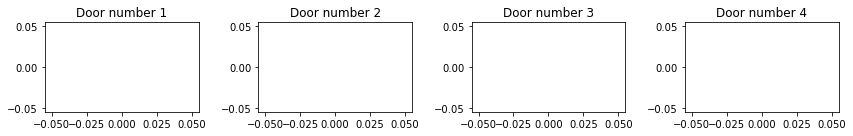

 Car number 3
 Graph for Train number 25 Car number 3 and Door number 1-4


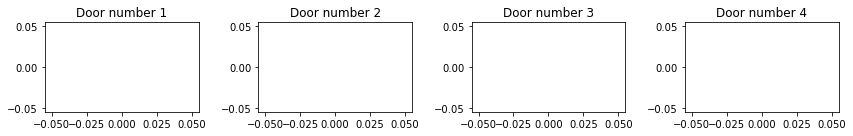

 Car number 4
 Graph for Train number 25 Car number 4 and Door number 1-4


 Car number 5
 Graph for Train number 25 Car number 5 and Door number 1-4


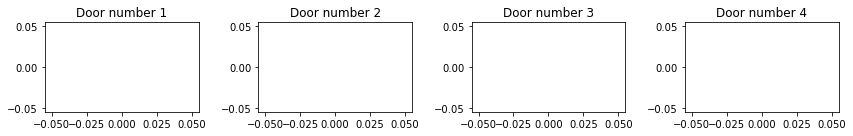

 Car number 6
 Graph for Train number 25 Car number 6 and Door number 1-4


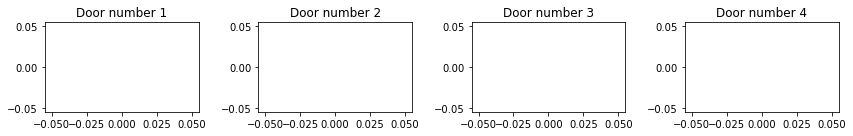

 Car number 7
 Graph for Train number 25 Car number 7 and Door number 1-4


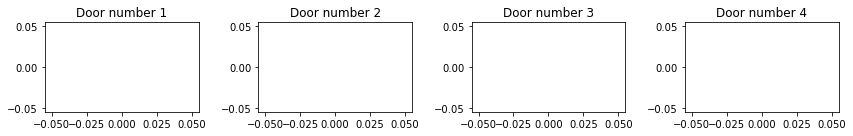

 Car number 8
 Graph for Train number 25 Car number 8 and Door number 1-4


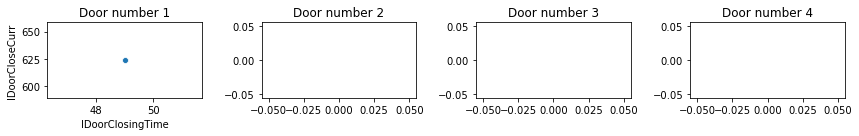

 Train number 48
 Car number 1
 Graph for Train number 48 Car number 1 and Door number 1-4


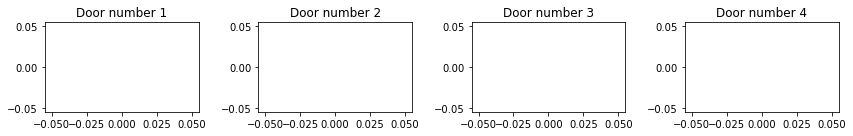

 Car number 2
 Graph for Train number 48 Car number 2 and Door number 1-4


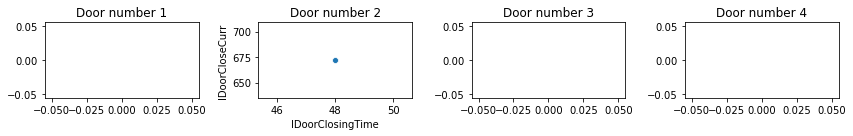

 Car number 3
 Graph for Train number 48 Car number 3 and Door number 1-4


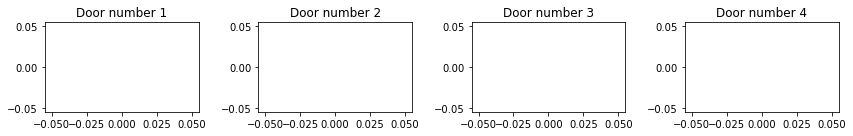

 Car number 4
 Graph for Train number 48 Car number 4 and Door number 1-4


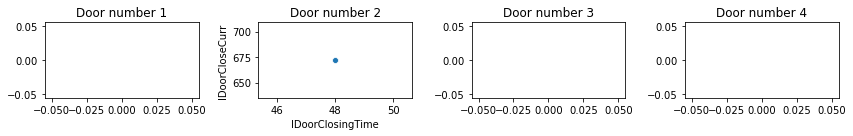

 Car number 5
 Graph for Train number 48 Car number 5 and Door number 1-4


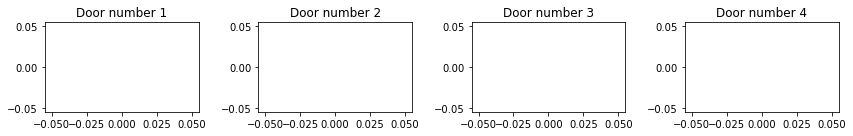

 Car number 6
 Graph for Train number 48 Car number 6 and Door number 1-4


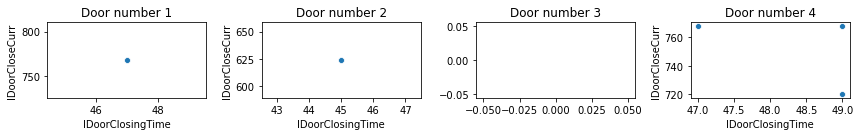

 Car number 7
 Graph for Train number 48 Car number 7 and Door number 1-4


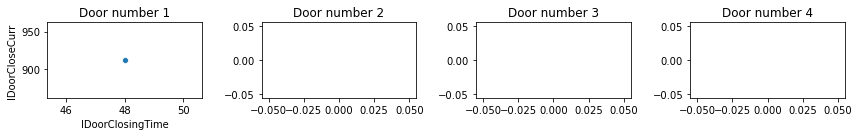

 Car number 8
 Graph for Train number 48 Car number 8 and Door number 1-4


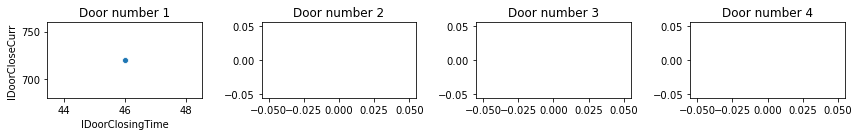

In [34]:
for i in strange_trains:
    print('\033[1m Train number %s' %i)
    for k in range(1,len(set(df_strange['ICstCarNo']))+1):
        plt.figure(figsize=(12, 2))
        print('\033[1m Car number %s' %k)
        print('\033[0m Graph for Train number %s Car number %s and Door number 1-4' %(i,k))
        for j in range(1,len(set(df_strange['Door']))+1):
            plt.subplot(1, 4, j)
            sns.scatterplot(df_strange['IDoorClosingTime'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i)& \
                    (df_strange['ICstCarNo'] == k)],\
                    df_strange['IDoorCloseCurr'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i) & \
                    (df_strange['ICstCarNo'] == k)])
            plt.title('Door number ' + str(j))
        plt.tight_layout()
        plt.show()

*And now the same but with opening and closing time and currents of the step:*

 Train number 15
 Car number 1
 Graph for Train number 15 Car number 1 and Door number 1-4


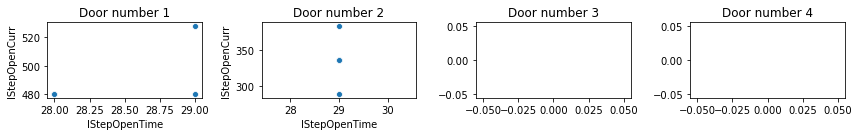

 Car number 2
 Graph for Train number 15 Car number 2 and Door number 1-4


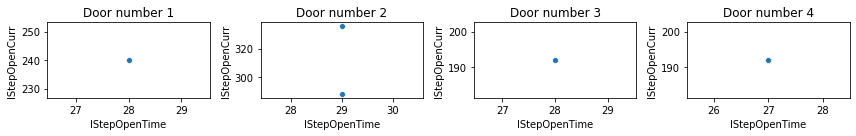

 Car number 3
 Graph for Train number 15 Car number 3 and Door number 1-4


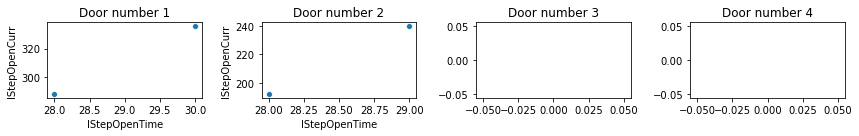

 Car number 4
 Graph for Train number 15 Car number 4 and Door number 1-4


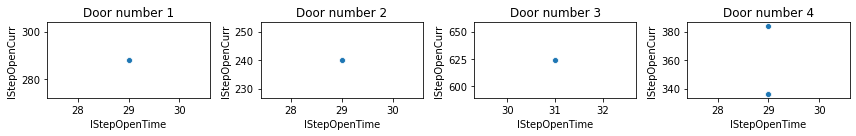

 Car number 5
 Graph for Train number 15 Car number 5 and Door number 1-4


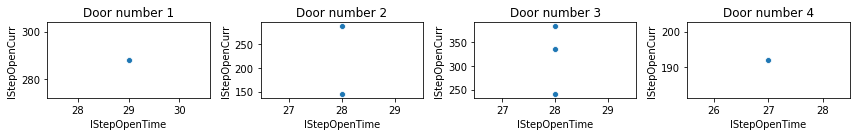

 Car number 6
 Graph for Train number 15 Car number 6 and Door number 1-4


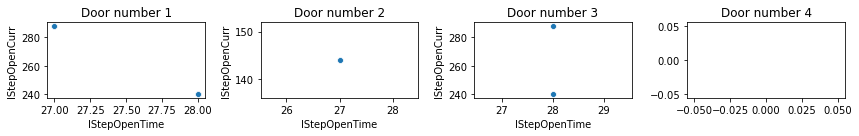

 Car number 7
 Graph for Train number 15 Car number 7 and Door number 1-4


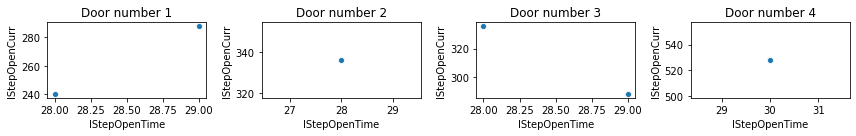

 Car number 8
 Graph for Train number 15 Car number 8 and Door number 1-4


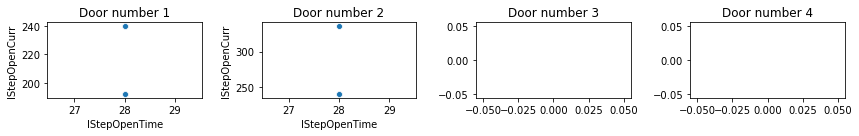

 Train number 25
 Car number 1
 Graph for Train number 25 Car number 1 and Door number 1-4


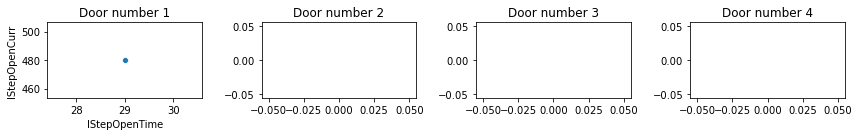

 Car number 2
 Graph for Train number 25 Car number 2 and Door number 1-4


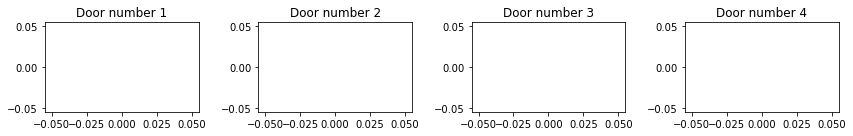

 Car number 3
 Graph for Train number 25 Car number 3 and Door number 1-4


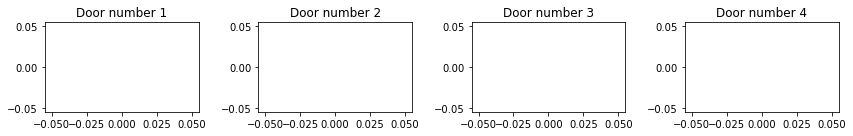

 Car number 4
 Graph for Train number 25 Car number 4 and Door number 1-4


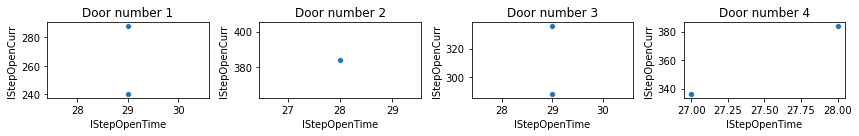

 Car number 5
 Graph for Train number 25 Car number 5 and Door number 1-4


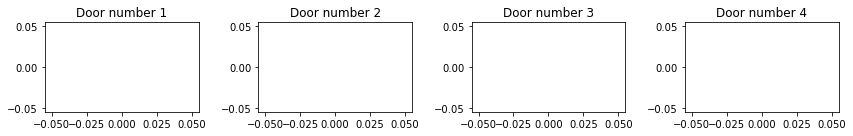

 Car number 6
 Graph for Train number 25 Car number 6 and Door number 1-4


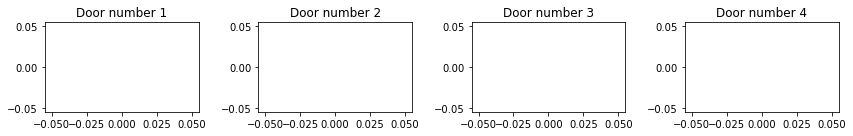

 Car number 7
 Graph for Train number 25 Car number 7 and Door number 1-4


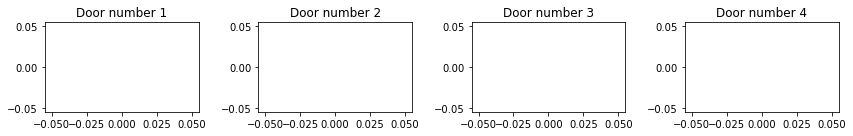

 Car number 8
 Graph for Train number 25 Car number 8 and Door number 1-4


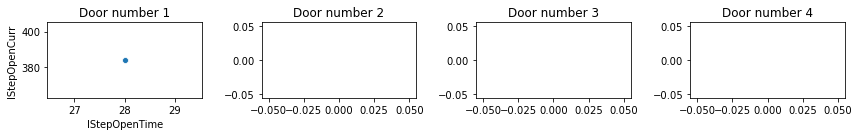

 Train number 48
 Car number 1
 Graph for Train number 48 Car number 1 and Door number 1-4


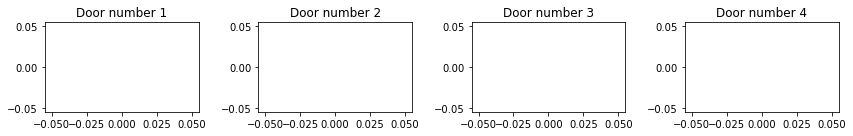

 Car number 2
 Graph for Train number 48 Car number 2 and Door number 1-4


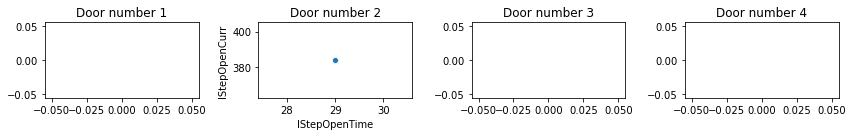

 Car number 3
 Graph for Train number 48 Car number 3 and Door number 1-4


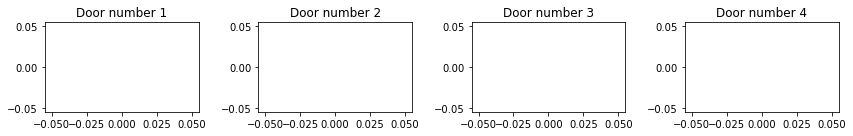

 Car number 4
 Graph for Train number 48 Car number 4 and Door number 1-4


 Car number 5
 Graph for Train number 48 Car number 5 and Door number 1-4


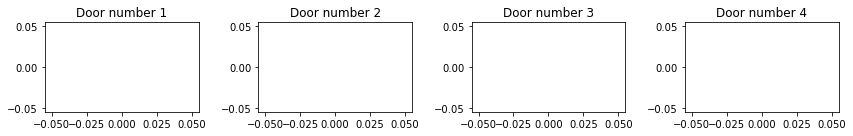

 Car number 6
 Graph for Train number 48 Car number 6 and Door number 1-4


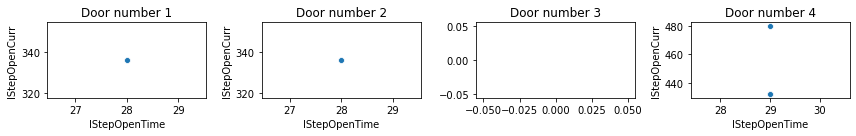

 Car number 7
 Graph for Train number 48 Car number 7 and Door number 1-4


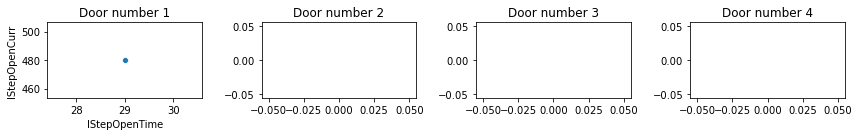

 Car number 8
 Graph for Train number 48 Car number 8 and Door number 1-4


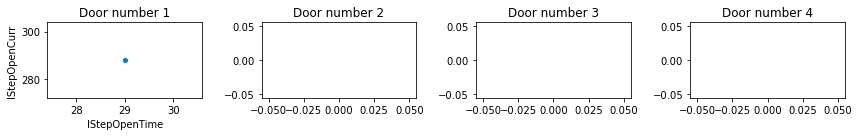

In [35]:
for i in strange_trains:
    print('\033[1m Train number %s' %i)
    for k in range(1,len(set(df_strange['ICstCarNo']))+1):
        plt.figure(figsize=(12, 2))
        print('\033[1m Car number %s' %k)
        print('\033[0m Graph for Train number %s Car number %s and Door number 1-4' %(i,k))
        for j in range(1,len(set(df_strange['Door']))+1):
            plt.subplot(1, 4, j)
            sns.scatterplot(df_strange['IStepOpenTime'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i)& \
                    (df_strange['ICstCarNo'] == k)],\
                    df_strange['IStepOpenCurr'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i) & \
                    (df_strange['ICstCarNo'] == k)])
            plt.title('Door number ' + str(j))
        plt.tight_layout()
        plt.show()

 Train number 15
 Car number 1
 Graph for Train number 15 Car number 1 and Door number 1-4


 Car number 2
 Graph for Train number 15 Car number 2 and Door number 1-4


 Car number 3
 Graph for Train number 15 Car number 3 and Door number 1-4


 Car number 4
 Graph for Train number 15 Car number 4 and Door number 1-4


 Car number 5
 Graph for Train number 15 Car number 5 and Door number 1-4


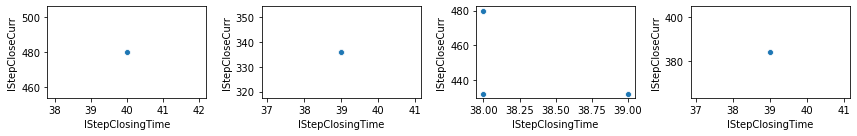

 Car number 6
 Graph for Train number 15 Car number 6 and Door number 1-4


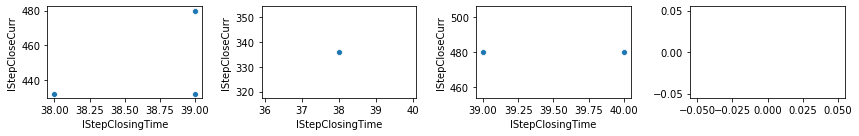

 Car number 7
 Graph for Train number 15 Car number 7 and Door number 1-4


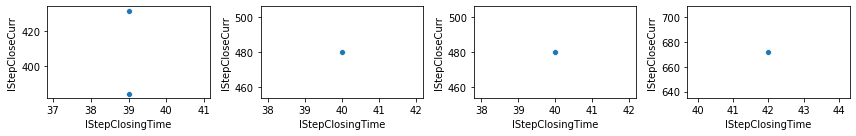

 Car number 8
 Graph for Train number 15 Car number 8 and Door number 1-4


 Train number 25
 Car number 1
 Graph for Train number 25 Car number 1 and Door number 1-4


 Car number 2
 Graph for Train number 25 Car number 2 and Door number 1-4


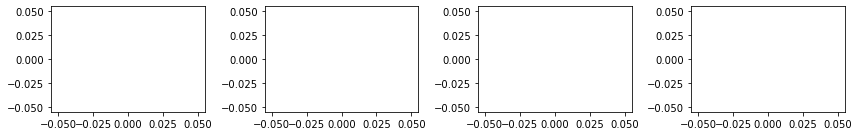

 Car number 3
 Graph for Train number 25 Car number 3 and Door number 1-4


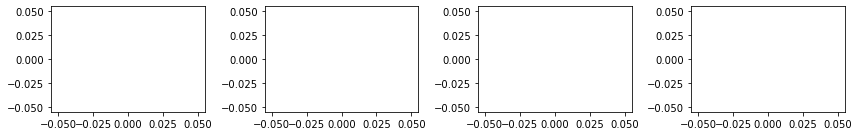

 Car number 4
 Graph for Train number 25 Car number 4 and Door number 1-4


 Car number 5
 Graph for Train number 25 Car number 5 and Door number 1-4


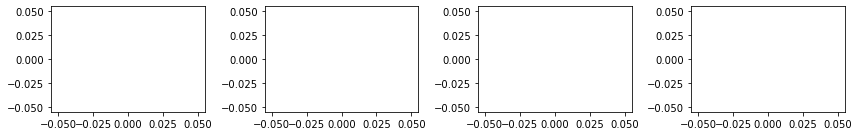

 Car number 6
 Graph for Train number 25 Car number 6 and Door number 1-4


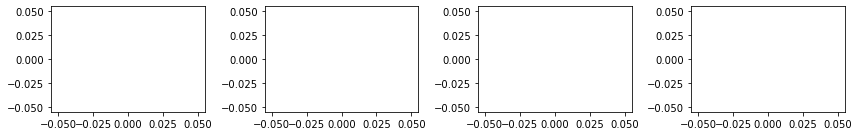

 Car number 7
 Graph for Train number 25 Car number 7 and Door number 1-4


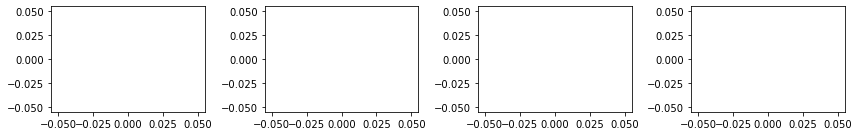

 Car number 8
 Graph for Train number 25 Car number 8 and Door number 1-4


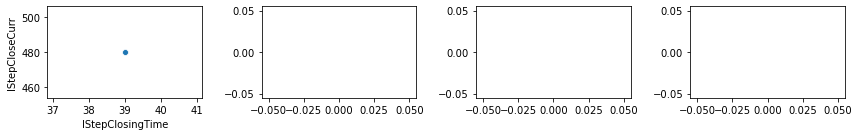

 Train number 48
 Car number 1
 Graph for Train number 48 Car number 1 and Door number 1-4


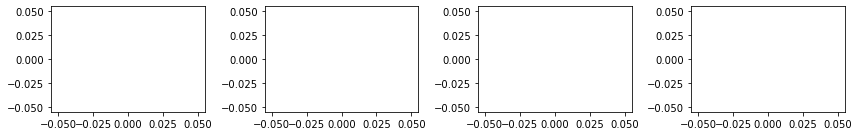

 Car number 2
 Graph for Train number 48 Car number 2 and Door number 1-4


 Car number 3
 Graph for Train number 48 Car number 3 and Door number 1-4


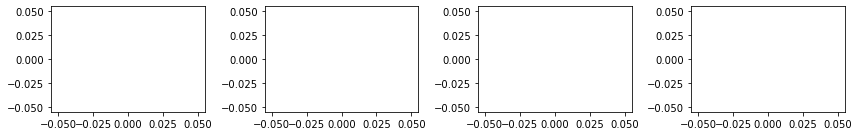

 Car number 4
 Graph for Train number 48 Car number 4 and Door number 1-4


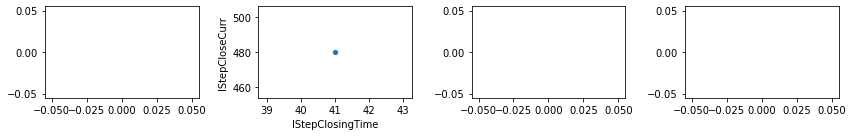

 Car number 5
 Graph for Train number 48 Car number 5 and Door number 1-4


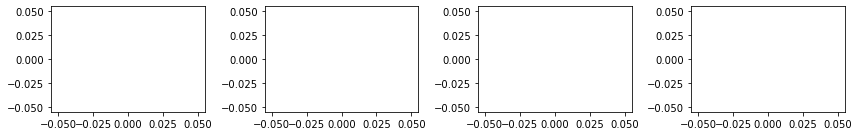

 Car number 6
 Graph for Train number 48 Car number 6 and Door number 1-4


 Car number 7
 Graph for Train number 48 Car number 7 and Door number 1-4


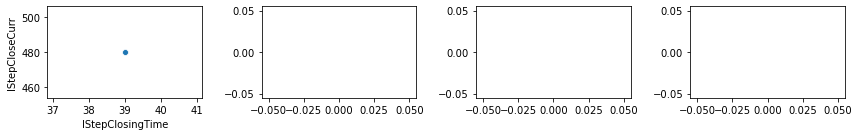

 Car number 8
 Graph for Train number 48 Car number 8 and Door number 1-4


In [36]:
for i in strange_trains:
    print('\033[1m Train number %s' %i)
    for k in range(1,len(set(df_strange['ICstCarNo']))+1):
        plt.figure(figsize=(12, 2))
        print('\033[1m Car number %s' %k)
        print('\033[0m Graph for Train number %s Car number %s and Door number 1-4' %(i,k))
        for j in range(1,len(set(df_strange['Door']))+1):
            plt.subplot(1, 4, j)
            sns.scatterplot(df_strange['IStepClosingTime'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i)& \
                    (df_strange['ICstCarNo'] == k)],\
                    df_strange['IStepCloseCurr'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i) & \
                    (df_strange['ICstCarNo'] == k)])
        plt.tight_layout()
        plt.show()

*Since not even this seems to be the potential cause of troubles we now check locking and unlocking currents*

 Train number 15
 Car number 1
 Graph for Train number 15 Car number 1 and Door number 1-4


 Car number 2
 Graph for Train number 15 Car number 2 and Door number 1-4


 Car number 3
 Graph for Train number 15 Car number 3 and Door number 1-4


 Car number 4
 Graph for Train number 15 Car number 4 and Door number 1-4


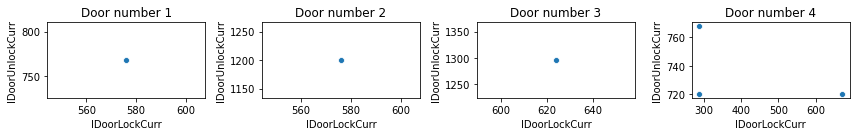

 Car number 5
 Graph for Train number 15 Car number 5 and Door number 1-4


 Car number 6
 Graph for Train number 15 Car number 6 and Door number 1-4


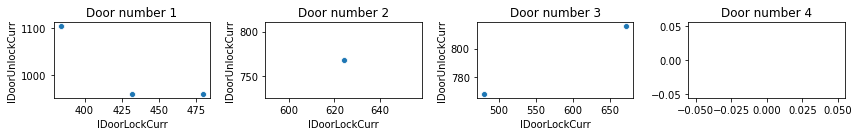

 Car number 7
 Graph for Train number 15 Car number 7 and Door number 1-4


 Car number 8
 Graph for Train number 15 Car number 8 and Door number 1-4


 Train number 25
 Car number 1
 Graph for Train number 25 Car number 1 and Door number 1-4


 Car number 2
 Graph for Train number 25 Car number 2 and Door number 1-4


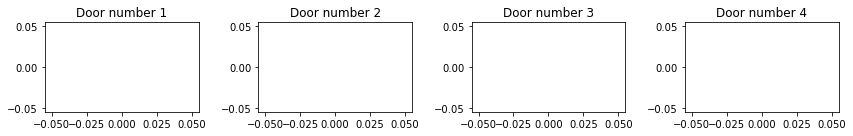

 Car number 3
 Graph for Train number 25 Car number 3 and Door number 1-4


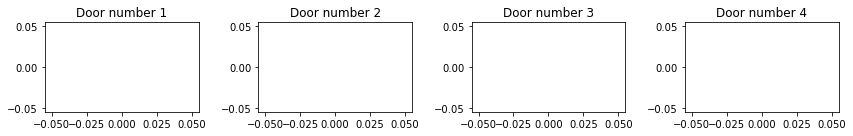

 Car number 4
 Graph for Train number 25 Car number 4 and Door number 1-4


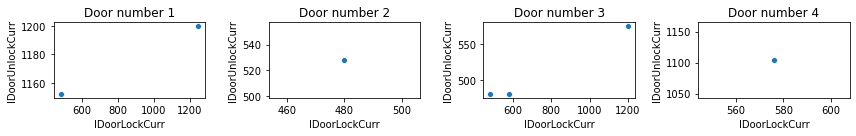

 Car number 5
 Graph for Train number 25 Car number 5 and Door number 1-4


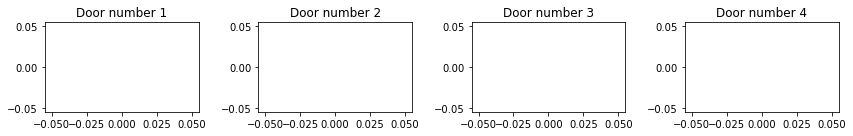

 Car number 6
 Graph for Train number 25 Car number 6 and Door number 1-4


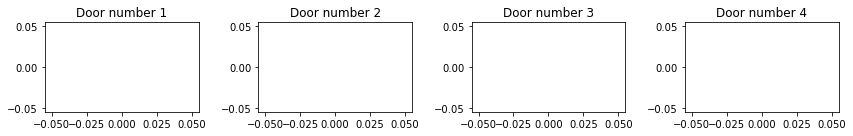

 Car number 7
 Graph for Train number 25 Car number 7 and Door number 1-4


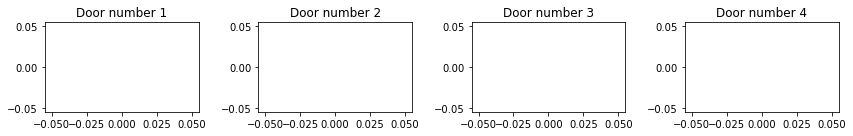

 Car number 8
 Graph for Train number 25 Car number 8 and Door number 1-4


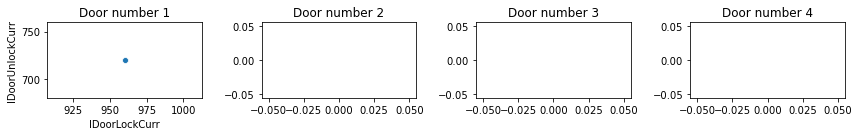

 Train number 48
 Car number 1
 Graph for Train number 48 Car number 1 and Door number 1-4


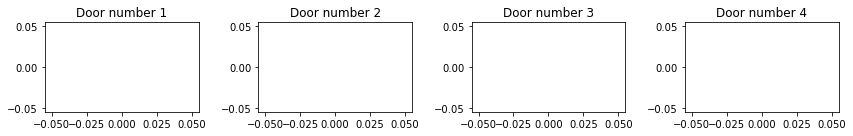

 Car number 2
 Graph for Train number 48 Car number 2 and Door number 1-4


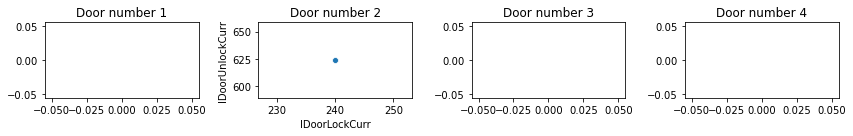

 Car number 3
 Graph for Train number 48 Car number 3 and Door number 1-4


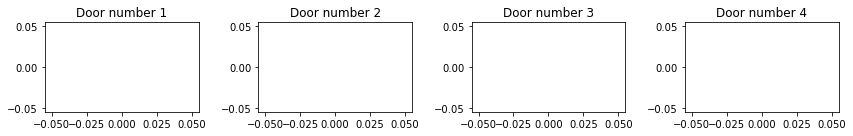

 Car number 4
 Graph for Train number 48 Car number 4 and Door number 1-4


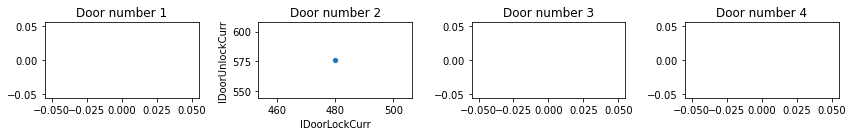

 Car number 5
 Graph for Train number 48 Car number 5 and Door number 1-4


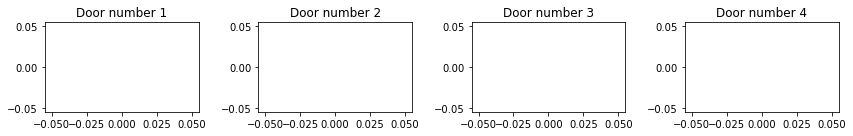

 Car number 6
 Graph for Train number 48 Car number 6 and Door number 1-4


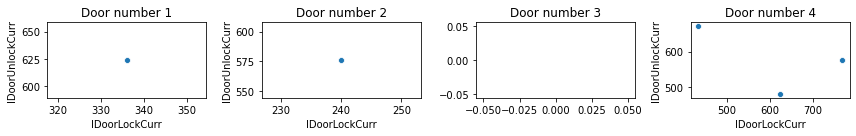

 Car number 7
 Graph for Train number 48 Car number 7 and Door number 1-4


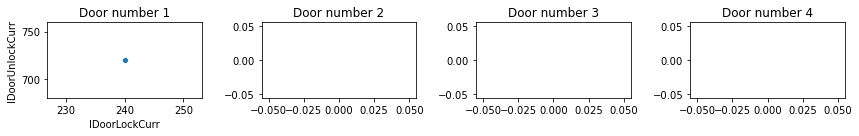

 Car number 8
 Graph for Train number 48 Car number 8 and Door number 1-4


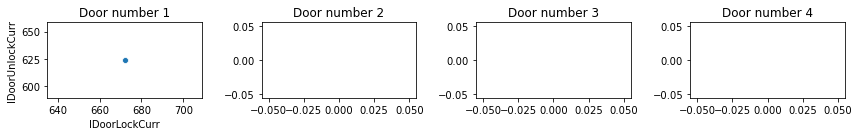

In [37]:
for i in strange_trains:
    print('\033[1m Train number %s' %i)
    for k in range(1,len(set(df_strange['ICstCarNo']))+1):
        plt.figure(figsize=(12, 2))
        print('\033[1m Car number %s' %k)
        print('\033[0m Graph for Train number %s Car number %s and Door number 1-4' %(i,k))
        for j in range(1,len(set(df_strange['Door']))+1):
            plt.subplot(1, 4, j)
            sns.scatterplot(df_strange['IDoorLockCurr'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i)& \
                    (df_strange['ICstCarNo'] == k)],\
                    df_strange['IDoorUnlockCurr'][(df_strange['Door'] == j) & (df_strange['vehicle_name'] == i) & \
                    (df_strange['ICstCarNo'] == k)])
            plt.title('Door number ' + str(j))
        plt.tight_layout()
        plt.show()

No expected abnormal behaviors have been shown.

**Disappointed we continue in the analysis.**

# 3.Data Visualization

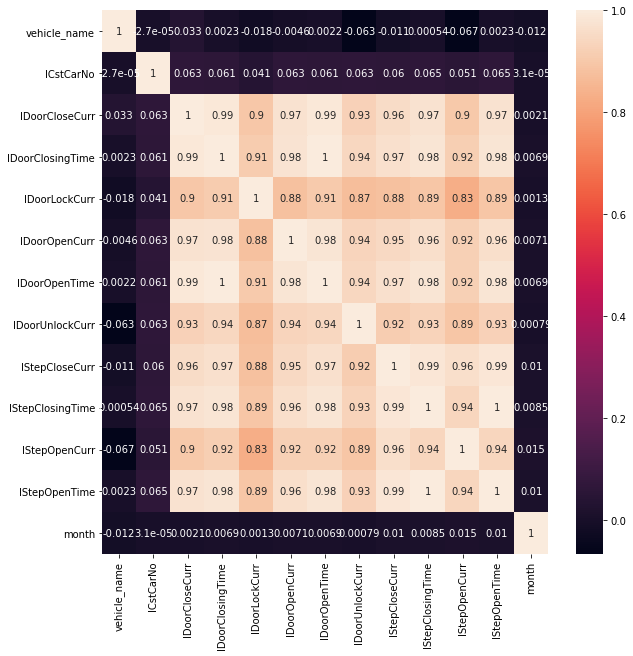

In [38]:
corrMatrix = df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, ax=ax)

In order to effectively show data we create an auxiliary df that we call df_visual that will be used only in this section.

In [39]:
df_float = df_no_zeros.select_dtypes(exclude=['object']).drop(['vehicle_name','month','sample_timestamp','ICstCarNo'], axis =1)
df_visual = df_float[(np.abs(stats.zscore(df_float)) < 3).all(axis=1)]

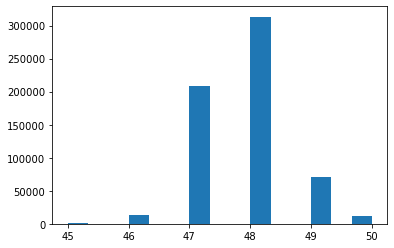

In [40]:
plt.hist(df_visual['IDoorClosingTime'], bins = 15)
plt.show()

In [41]:
plt.hist(df_visual['IDoorOpenTime'],bins=15)
plt.show()

In [42]:
plt.hist(df_visual['IStepClosingTime'],bins=15)
plt.show()

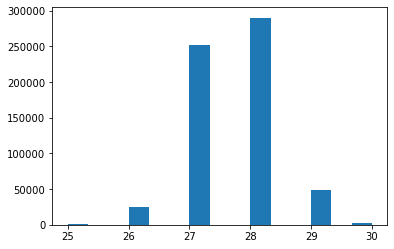

In [43]:
plt.hist(df_visual['IStepOpenTime'],bins=15)
plt.show()

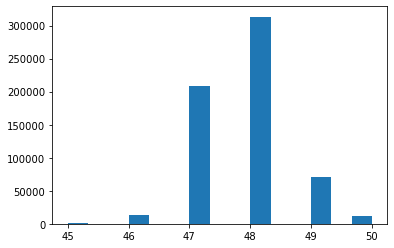

In [44]:
plt.hist(df_visual['IDoorClosingTime'], bins = 15)
plt.show()

In [45]:
plt.hist(df_visual['IDoorOpenTime'],bins=15)
plt.show()

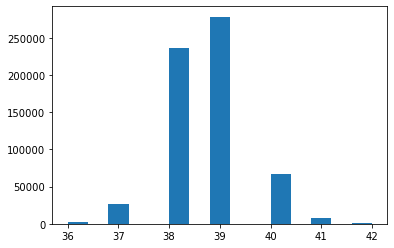

In [46]:
plt.hist(df_visual['IStepClosingTime'],bins=15)
plt.show()

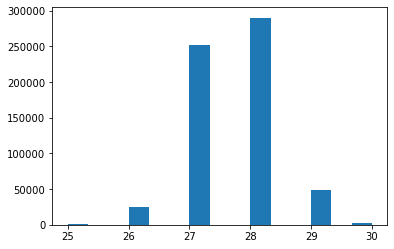

In [47]:
plt.hist(df_visual['IStepOpenTime'],bins=15)
plt.show()

In [48]:
plt.hist(df_visual['IDoorCloseCurr'],bins=15)
plt.show()

We assume the reason behind the distribution of the above bins is in the recording methods.

In [49]:
sns.scatterplot(df['IDoorCloseCurr'],df['IDoorOpenCurr'])
plt.title('Door Closing vs Opening current')

Text(0.5, 1.0, 'Door Closing vs Opening current')

*In the above plot we can clearly see two major groups, on which we will work on later, and values for Door Closing current less than zero, which seems a bit strange.*

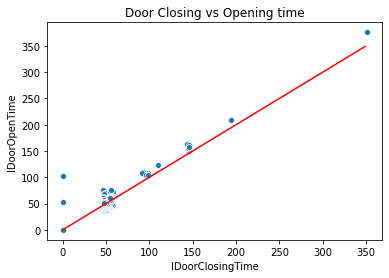

In [50]:
sns.scatterplot(df['IDoorClosingTime'],df['IDoorOpenTime'])
plt.title('Door Closing vs Opening time')
x = range(0,350)
plt.plot(x,x, 'r')

*Opening and closing time seem to be pretty much the same for all data points, even though some outlier appear. As a matter of fact there are both recorded closing times of 0 ms (which of course doesn't seem viable only in the cases in which the recorded Opening Time for the said data points differs from zero) and opening/closing times of over 35 seconds, which are clearly way too much. We also consider strange datapoints with opening/closing time of around 10 seconds, so we will investigate that data as well.*

Text(0.5, 1.0, 'Step Closing vs Opening current')

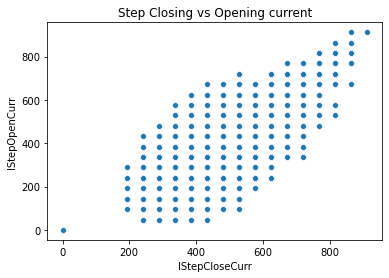

In [51]:
sns.scatterplot(df['IStepCloseCurr'],df['IStepOpenCurr'])
plt.title('Step Closing vs Opening current')

*Data with current of zero could just be the one about doors that didn't open at the stop, so even though it may seem strange we consider them normal.*

Text(0.5, 1.0, 'Door Closing Time vs Current')

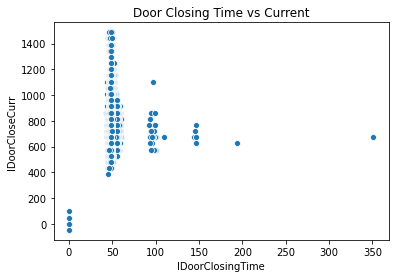

In [52]:
sns.scatterplot(df['IDoorClosingTime'],df['IDoorCloseCurr'])
plt.title('Door Closing Time vs Current')

Text(0.5, 1.0, 'Door Opening Time vs Current')

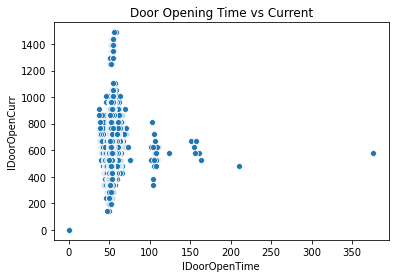

In [53]:
sns.scatterplot(df['IDoorOpenTime'],df['IDoorOpenCurr'])
plt.title('Door Opening Time vs Current')

*The previous graphs show some distinct behaviors in the distribution of Opening/ Closing times, which may be related to different trains being different models as well.*

Text(0.5, 1.0, 'Step closing Time vs Current ')

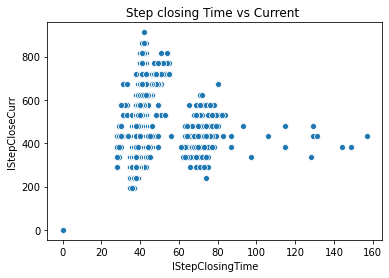

In [54]:
sns.scatterplot(df['IStepClosingTime'],df['IStepCloseCurr'])
plt.title('Step closing Time vs Current ')

# 4.Data Analysis following Visualization intuitions

We show again the plot in cell 43, in which two groups were easily identifiable:

Text(0.5, 1.0, 'Door Closing vs Opening current')

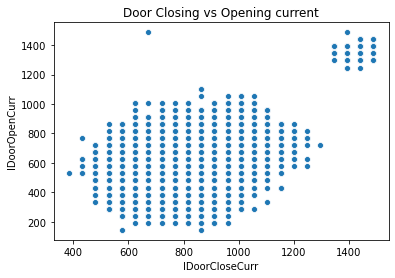

In [55]:
sns.scatterplot(df_no_zeros['IDoorCloseCurr'],df_no_zeros['IDoorOpenCurr'])
plt.title('Door Closing vs Opening current')

Our opinion is that thanks to the clear distinction between the groups we may be able to identify the vehicle's names relating to the different behaviors and then make thesis about the presence of different types of doors. **IF** each vehicle has values in **only** one of the two groups then our hypothesis could be proven. 

At first we seek the data points that happen to be in the group on the right:

In [56]:
DP_Right = df_no_zeros['vehicle_name'][df_no_zeros['IDoorOpenCurr'] > 1200]

and make a set out of it to extract the values:

In [57]:
set(DP_Right)

{10.0, 13.0}

then we do the same for the other group, the bigger on the left:

In [58]:
DP_Left = df_no_zeros['vehicle_name'][df_no_zeros['IDoorOpenCurr'] < 1200]

and make a set:

In [59]:
set(DP_Left)

{1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0}

Then we compare the two:

In [60]:
for i in set(DP_Right):
    if i in set(DP_Left):
        print('train number %s is in both groups and there is no evidence that it could be a different train' %i)
    else:
        print('oh no')

train number 10.0 is in both groups and there is no evidence that it could be a different train
train number 13.0 is in both groups and there is no evidence that it could be a different train


Since the two trains that were representative of the right group are both present in the left one we can't tell if there is a strict difference in trains.

We now try the same logic process but with Open time of doors as anticipated in cell number 47.

In [61]:
DP_Right = df_no_zeros['vehicle_name'][df_no_zeros['IDoorOpenTime'] > 100]
DP_Left = df_no_zeros['vehicle_name'][df_no_zeros['IDoorOpenTime'] < 100]

In [62]:
for i in set(DP_Right):
    if i in set(DP_Left):
        print('train number %s is in both groups and there is no evidence that it could be a different train' %i)
    else:
        print('oh no')

train number 2.0 is in both groups and there is no evidence that it could be a different train
train number 4.0 is in both groups and there is no evidence that it could be a different train
train number 7.0 is in both groups and there is no evidence that it could be a different train
train number 9.0 is in both groups and there is no evidence that it could be a different train
train number 10.0 is in both groups and there is no evidence that it could be a different train
train number 13.0 is in both groups and there is no evidence that it could be a different train
train number 16.0 is in both groups and there is no evidence that it could be a different train
train number 18.0 is in both groups and there is no evidence that it could be a different train
train number 19.0 is in both groups and there is no evidence that it could be a different train
train number 20.0 is in both groups and there is no evidence that it could be a different train
train number 23.0 is in both groups and ther

We also did **not** countercheck because what we're seeing is if there is a variation from the 'group' behavior, which in other words made us seek the smallest in the biggest and not, of course, the opposite.

From what we got we can't express ourselves on the possibility of a difference in terms of trains.

In [63]:
df_visual

IDoorCloseCurr  IDoorClosingTime  IDoorLockCurr  IDoorOpenCurr  \
0                  768                48            624            432   
1                  624                47            576            576   
2                  624                49            720            528   
3                  528                47            816            528   
4                  720                48            288            720   
...                ...               ...            ...            ...   
657153             864                48            384            672   
657154             768                48            336            624   
657155             768                48            576            336   
657156             672                49           1104            480   
657158             816                48           1008            576   

        IDoorOpenTime  IDoorUnlockCurr  IStepCloseCurr  IStepClosingTime  \
0                  52              624             336                39   
1                  52             1008             384                38   
2                  52              576             480                38   
3                  54             1344             528                40   
4                  54              816             480                39   
...               ...              ...             ...               ...   
657153             53              624             480                38   
657154             51              768             384                39   
657155             51              576             528                40   
657156             51              624             336                38   
657158             53              672             432                40   

        IStepOpenCurr  IStepOpenTime  
0                 192             28  
1                 336             28  
2                 528             28  
3                 480             28  
4                 432             28  
...               ...            ...  
657153            384             28  
657154            288             28  
657155            384             29  
657156            240             28  
657158            336             28  

[618771 rows x 10 columns]

# 5.Regression

Due to the prevalence of zero values, together with them being not meaningful in any way, we did not consider them into 
linear prediction, that will however not produce reliable results.

As all the values are correlated with eachother it is hard to consider the features for performing predictions so 
we use Lasso Regression for feature selection and try to select suitable features to predict the door open time.

In [64]:
cor = df_visual.corr()
#Correlation with output variable
cor_target = abs(cor["IDoorOpenTime"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

IDoorOpenTime    1.0
Name: IDoorOpenTime, dtype: float64

In [65]:
X = df_visual.drop("IDoorOpenTime",1)   #Feature Matrix
y = df_visual["IDoorOpenTime"]  

In [66]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.038587
Best score using built-in LassoCV: 0.050758


In [67]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

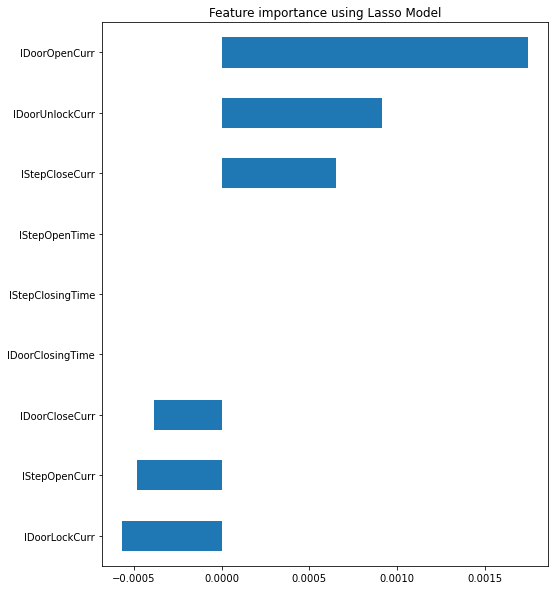

In [68]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Based on the results from the Lasso regression we predict the Door Open Time based on the Door Open Current using 
Linear regression.Next steps are to split in train and test data and to declare a regressor, fit it with train data 
and then predict.

In [69]:
samples = np.array(df_visual['IDoorOpenCurr']).reshape(-1,1)
label = np.array(df_visual['IDoorOpenTime']).reshape(-1,1)
samples_train, samples_test, label_train, label_test = \
    train_test_split(samples, label, test_size= 1/3.0, random_state =1234, shuffle=True)
samples_train.shape
regressor = LinearRegression()
regressor.fit(samples_train,label_train)
train_pred = regressor.predict(samples_train)
test_pred = regressor.predict(samples_test)
regressor.coef_, regressor.intercept_

(array([[0.00208755]]), array([50.87190261]))

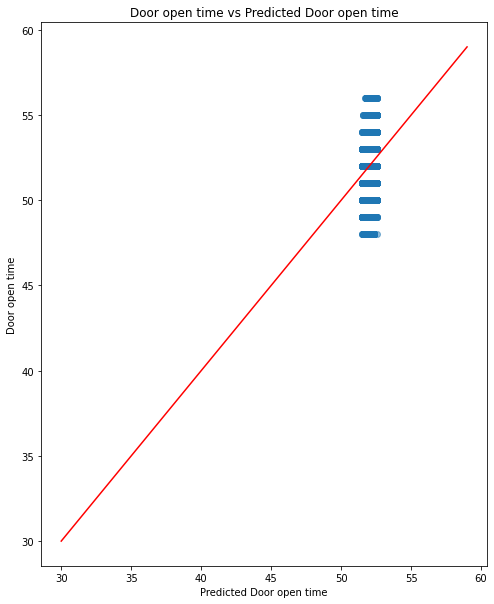

In [70]:
plt.scatter( test_pred, label_test, alpha = 0.5)
plt.xlabel("Predicted Door open time")
plt.ylabel("Door open time")
plt.title("Door open time vs Predicted Door open time")
x = np.arange(30,60)
plt.plot(x,x, c = 'red')

In [71]:
print('MAE', metrics.mean_absolute_error(label_test,test_pred))
print('MSE', metrics.mean_squared_error(label_test,test_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(label_test,test_pred)))
print("TRAIN R2 %.3f"%(r2_score(label_train,train_pred)))
print("TEST R2 %.3f"%(r2_score(label_test,test_pred)))

MAE 0.9079821997584532
MSE 1.4252021608775691
RMSE 1.1938183115020347
TRAIN R2 0.023
TEST R2 0.022


Selecting the best feature to predict the door closing time using Lasso Regression

In [72]:
X = df_visual.drop("IDoorClosingTime",1)   #Feature Matrix
y = df_visual["IDoorClosingTime"]  

In [73]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.084597
Best score using built-in LassoCV: 0.316222


In [74]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 6 variables and eliminated the other 3 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

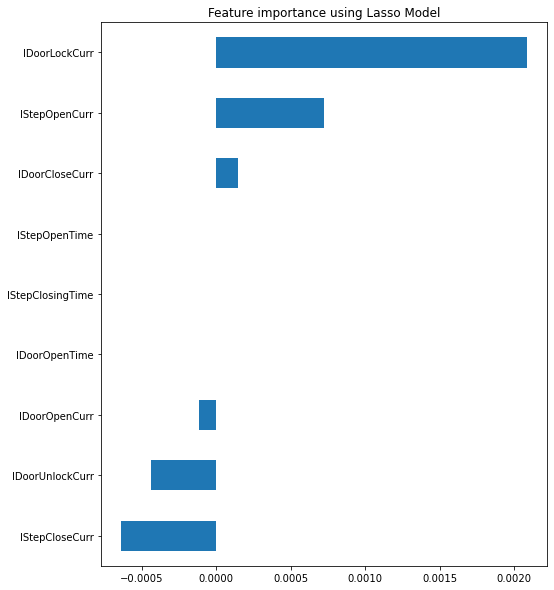

In [75]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

From the above results shows that Door Closing time is correlated to Door Lock Current so we use linear regression 
to predict Door Closing time using Door Lock Current.

In [76]:
samples = np.array(df_visual['IDoorLockCurr']).reshape(-1,1)
label = np.array(df_visual['IDoorClosingTime']).reshape(-1,1)
samples_train, samples_test, label_train, label_test = \
    train_test_split(samples, label, test_size= 1/3.0, random_state =1234, shuffle=True)
samples_train.shape
regressor = LinearRegression()
regressor.fit(samples_train,label_train)
train_pred = regressor.predict(samples_train)
test_pred = regressor.predict(samples_test)
regressor.coef_, regressor.intercept_

(array([[0.00202366]]), array([46.5811273]))

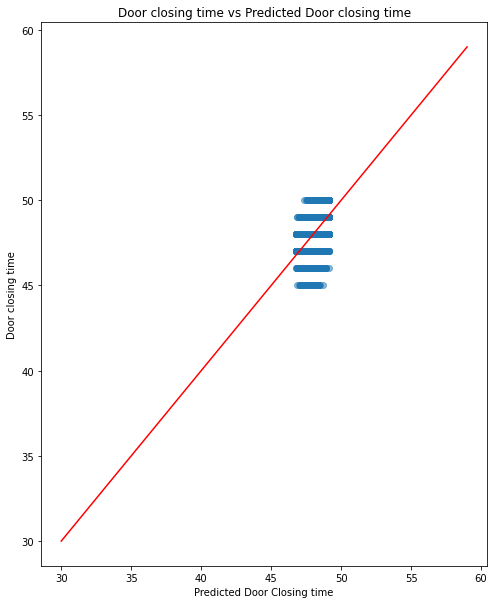

In [77]:
plt.scatter( test_pred, label_test, alpha = 0.5)
plt.xlabel("Predicted Door Closing time")
plt.ylabel("Door closing time")
plt.title("Door closing time vs Predicted Door closing time")
x = np.arange(30,60)
plt.plot(x,x, c = 'red')

In [78]:
print('MAE', metrics.mean_absolute_error(label_test,test_pred))
print('MSE', metrics.mean_squared_error(label_test,test_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(label_test,test_pred)))
print("TRAIN R2 %.3f"%(r2_score(label_train,train_pred)))
print("TEST R2 %.3f"%(r2_score(label_test,test_pred)))

MAE 0.5072115799253847
MSE 0.39729858020858727
RMSE 0.6303162541205702
TRAIN R2 0.300
TEST R2 0.303


In the following cells we try to predict the Opening current of the step based on the Closing one, considering the possibility of a inner relation between the two mechanisms and circuits. We follow a pretty basic approach in which we declare the samples on which we are gonna base our study as well as the information that we are trying to predict. Next steps are to split in train and test data and to declare a regressor, fit it with train data and then predict.

In [79]:
samples = np.array(df_no_zeros['IStepCloseCurr']).reshape(-1,1)
label = np.array(df_no_zeros['IStepOpenCurr']).reshape(-1,1)
samples_train, samples_test, label_train, label_test = \
    train_test_split(samples, label, test_size= 1/3.0, random_state =1234, shuffle=True)
samples_train.shape
regressor = LinearRegression()
regressor.fit(samples_train,label_train)
train_pred = regressor.predict(samples_train)
test_pred = regressor.predict(samples_test)
regressor.coef_, regressor.intercept_

(array([[1.07143852]]), array([-135.07965582]))

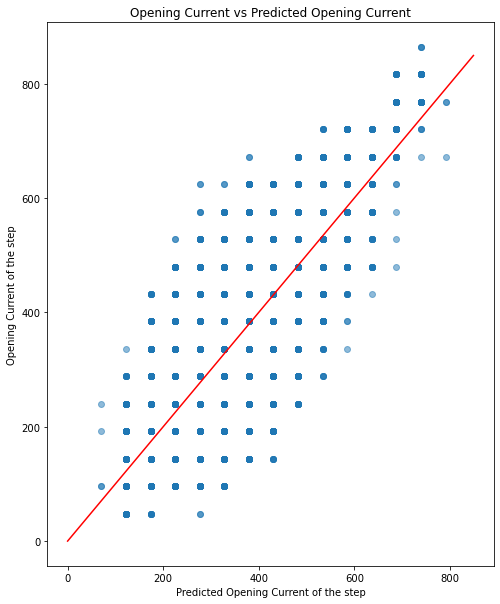

In [80]:
plt.scatter( test_pred, label_test, alpha = 0.5)
plt.xlabel("Predicted Opening Current of the step")
plt.ylabel("Opening Current of the step")
plt.title("Opening Current vs Predicted Opening Current")
x = np.arange(0,850)
plt.plot(x,x, c = 'red')

In [81]:
print('MAE', metrics.mean_absolute_error(label_test,test_pred))
print('MSE', metrics.mean_squared_error(label_test,test_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(label_test,test_pred)))
print("TRAIN R2 %.3f"%(r2_score(label_train,train_pred)))
print("TEST R2 %.3f"%(r2_score(label_test,test_pred)))

MAE 58.04287679621253
MSE 4972.520920778241
RMSE 70.51610398184404
TRAIN R2 0.480
TEST R2 0.479


In [82]:
samples = np.array(df_float.drop(['IStepCloseCurr'],axis = 1))
label = np.array(df_float['IStepCloseCurr'])
samples_train, samples_test, label_train, label_test = \
    train_test_split(samples, label,\
    test_size= 1/3.0, random_state =1234, shuffle=True)
label_train = label_train.reshape(-1,1)
label_test = label_test.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(samples_train,label_train)
train_pred = regressor.predict(samples_train)
test_pred = regressor.predict(samples_test)
regressor.coef_,regressor.intercept_

(array([[ 0.09239799, -2.20920506,  0.01853618, -0.12345191,  0.58546971,
         -0.02398378, 13.92707018,  0.47128975, -5.65648193]]),
 array([-22.21263657]))

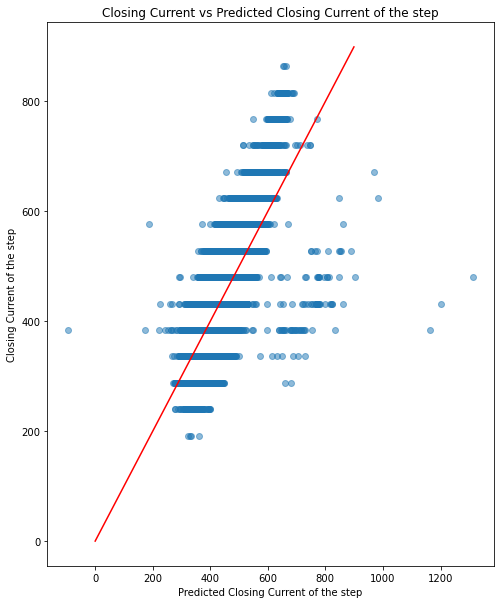

In [83]:
plt.scatter( test_pred, label_test, alpha = 0.5)
plt.xlabel("Predicted Closing Current of the step")
plt.ylabel("Closing Current of the step")
plt.title("Closing Current vs Predicted Closing Current of the step")
x = np.arange(0,900)
plt.plot(x,x, c = 'red')

In [84]:
print('MAE', metrics.mean_absolute_error(label_test,test_pred))
print('MSE', metrics.mean_squared_error(label_test,test_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(label_test,test_pred)))
print("TRAIN R2 %.3f"%(r2_score(label_train,train_pred)))
print("TEST R2 %.3f"%(r2_score(label_test,test_pred)))

MAE 32.36737353093251
MSE 1695.5325590048108
RMSE 41.17684493747439
TRAIN R2 0.575
TEST R2 0.577


The above results are in some way correct and should be used only to perceive a mean value around which the real Time in seconds could be. The large variance is an obstacle to more accurate predictions.

In [85]:
samples = np.array(df_no_zeros['IDoorCloseCurr'])
label = np.array(df_no_zeros['IDoorOpenCurr'])
samples_train, samples_test, label_train, label_test = \
    train_test_split(samples, label,\
    test_size= 1/3.0, random_state =1234, shuffle=True)
samples_train = samples_train.reshape(-1,1)
label_train = label_train.reshape(-1,1)
samples_test = samples_test.reshape(-1,1)
label_test = label_test.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(samples_train,label_train)
train_pred = regressor.predict(samples_train)
test_pred = regressor.predict(samples_test)
regressor.coef_,regressor.intercept_

(array([[0.23310295]]), array([385.52878036]))

In [86]:
plt.scatter( test_pred, label_test, alpha = 0.5)
plt.xlabel("Predicted Opening Current of the door")
plt.ylabel("Opening Current of the door")
plt.title("Opening Current vs Predicted Opening Current of the door")
x = np.arange(450,750)
plt.plot(x,x, c = 'red')

In [87]:
print('MAE', metrics.mean_absolute_error(label_test,test_pred))
print('MSE', metrics.mean_squared_error(label_test,test_pred))
print('RMSE',np.sqrt(metrics.mean_squared_error(label_test,test_pred)))
print("TRAIN R2 %.3f"%(r2_score(label_train,train_pred)))
print("TEST R2 %.3f"%(r2_score(label_test,test_pred)))

MAE 71.82463021696027
MSE 8105.846767506352
RMSE 90.03247618224411
TRAIN R2 0.047
TEST R2 0.048


Are these results good? No! The reason is in the data distribution, that presents an enormous variance around a possible linear prediction. We do not suggest to rely on prediction for this problem.

# 6.Classification

Considering the results obtained from data visualization we now try to identify the vehicle name using the other informations available. If the predictions happen to be pretty accurate it means that there is some inner link between them, and all trains may not be the same. We start by considering again df_no_zeros, our dataframe that got rid of zero values, that are not meaningful in terms of predicting anything.

In [88]:
df_no_zeros

sample_timestamp  vehicle_name   processor_name  ICstCarNo  \
0      2020-06-02 06:57:55          42.0  DCU1.car08.lCst          8   
1      2020-06-02 13:49:01           4.0  DCU4.car05.lCst          5   
2      2020-06-02 13:49:01           4.0  DCU2.car03.lCst          3   
3      2020-06-02 13:49:01           4.0  DCU3.car05.lCst          5   
4      2020-06-02 13:49:01           4.0  DCU1.car03.lCst          3   
...                    ...           ...              ...        ...   
657155 2020-10-30 23:09:15          44.0  DCU2.car07.lCst          7   
657156 2020-10-30 23:09:15          44.0  DCU1.car02.lCst          2   
657157 2020-10-30 23:39:43          26.0  DCU1.car05.lCst          5   
657158 2020-10-30 23:39:43          26.0  DCU1.car08.lCst          8   
657159 2020-10-30 23:58:09          44.0  DCU1.car01.lCst          1   

        IDoorCloseCurr  IDoorClosingTime  IDoorLockCurr  IDoorOpenCurr  \
0                  768                48            624            432   
1                  624                47            576            576   
2                  624                49            720            528   
3                  528                47            816            528   
4                  720                48            288            720   
...                ...               ...            ...            ...   
657155             768                48            576            336   
657156             672                49           1104            480   
657157             720                50           1200            672   
657158             816                48           1008            576   
657159             672                48           1008            624   

        IDoorOpenTime  IDoorUnlockCurr  IStepCloseCurr  IStepClosingTime  \
0                  52              624             336                39   
1                  52             1008             384                38   
2                  52              576             480                38   
3                  54             1344             528                40   
4                  54              816             480                39   
...               ...              ...             ...               ...   
657155             51              576             528                40   
657156             51              624             336                38   
657157             51             1296             720                43   
657158             53              672             432                40   
657159             52              432             384                77   

        IStepOpenCurr  IStepOpenTime      day        date      time  month  \
0                 192             28  Tuesday  2020-06-02  06:57:55      6   
1                 336             28  Tuesday  2020-06-02  13:49:01      6   
2                 528             28  Tuesday  2020-06-02  13:49:01      6   
3                 480             28  Tuesday  2020-06-02  13:49:01      6   
4                 432             28  Tuesday  2020-06-02  13:49:01      6   
...               ...            ...      ...         ...       ...    ...   
657155            384             29   Friday  2020-10-30  23:09:15     10   
657156            240             28   Friday  2020-10-30  23:09:15     10   
657157            624             29   Friday  2020-10-30  23:39:43     10   
657158            336             28   Friday  2020-10-30  23:39:43     10   
657159            240             57   Friday  2020-10-30  23:58:09     10   

       Door  
0         1  
1         4  
2         2  
3         3  
4         1  
...     ...  
657155    2  
657156    1  
657157    1  
657158    1  
657159    1  

[657160 rows x 19 columns]

We declare a scaler that will map the datapoints in a different range:

In [89]:
sc = StandardScaler()

We proceed to both drop columns that won't be used for the analysis and rearrange the dat that instead will be used with the scaler precedently declared:

From now on we follow a pretty standard path in regression, which is:
1) train-test split

2) declaration of classifier

3) fit and predict

The chosen classifiers are : 
1) Logistic Regression;

2) Naive Bayes Classifier;

3) KNN;

4) Random Forest.

First we rearrange the data and do the train test split:

In [90]:
df_class = df_no_zeros.drop(['vehicle_name', 'time','day','processor_name','sample_timestamp','date' ], axis = 1)
X = np.array(df_class)
y = np.array(df_no_zeros['vehicle_name']).ravel()
sc.fit(X)
X = sc.transform(X)
X.shape, y.shape

((657160, 13), (657160,))

In [91]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,\
    test_size= 1/2.0, random_state =1234, shuffle=True)

### Logistic Regression

In [92]:
lr = LogisticRegression(penalty='none', 
                        solver='lbfgs',
                        multi_class='multinomial',
                        max_iter=100000,
                        random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=100000, multi_class='multinomial', penalty='none',
                   random_state=1)

In [93]:
print('accuracy:'+str(accuracy_score(y_test, lr.predict(X_test))))

accuracy:0.14291801083449998


### KNN

In [94]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [95]:
y_pred = knn.predict(X_train)
print('accuracy:'+str(accuracy_score(y_test,y_pred)))

accuracy:0.0221711607523282


### Naive Bayes

In [96]:
y = label_binarize(y, classes = np.arange(0,51))
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,\
    test_size= 1/2.0, random_state =1234, shuffle=True)

In [97]:
nb = OneVsRestClassifier(GaussianNB())
nb.fit(X_train, y_train)
y_proba = nb.predict_proba(X_test)
y_proba[0].shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 21 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


(51,)

In [98]:
average_precision_score(y_test.ravel(),y_proba.ravel())

0.07296763461480708

As it's possible to see from above cell results are pretty cheap, combined with a long computational time, so we try instead another classifier, together with an ensemble method.
The choice for decision trees comes from the natural partition that the data seems to posses, as clearly visible from the DoorOpenTime vs DoorOpenCurr (and similar) plots (cell number 34). 

### Random Forest

In [99]:
y = np.array(df_no_zeros['vehicle_name']).ravel()

In [100]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,\
    test_size= 1/2.0, random_state =1234, shuffle=True)

In [101]:
n_trees = [1, 2, 4, 8, 16, 32, 64]
for n in n_trees:
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    print('number of trees='+str(n)+' accuracy: '+str(accuracy_score(y_test, clf.predict(X_test))))

number of trees=1 accuracy: 0.648143526690608
number of trees=2 accuracy: 0.6544220585549942
number of trees=4 accuracy: 0.7750563028790554
number of trees=8 accuracy: 0.8297918315174386
number of trees=16 accuracy: 0.8588897680930063
number of trees=32 accuracy: 0.8729594010591029
number of trees=64 accuracy: 0.8792714103110354


As the number of trees goes up the accuracy grows to reach nearly 90%, value for which we consider ourselves satisfied.

# 7.Conclusions

Data presents an enormous variance around the predictable values, which makes it not reliable for prediction, although some classification techniques seem to be pretty efficient.

No abnormal patterns were identified deep enough to make hypothesis on the nature of train composition. 

The average values seem to be pretty stable and if given more infos some deeper analysis could be carried on the Strange Trains identified. 

We thank Hitachi for the data. 